# Full Pipeline Evaluation: Graph Building + HTE + EBM + Langevin + Decoder + LP Worker

**Complete pipeline on 40 eval scenarios:**

1. **Build Hierarchical Temporal Graphs** from eval scenario JSONs
2. **Generate HTE Embeddings** using trained encoder (`best_encoder_with_norm.pt`)
3. **Extract Zone-level Embeddings** for EBM input
4. **EBM + Normalized Temporal Langevin Sampler** - binary candidates
5. **Hierarchical Feasibility Decoder** - enforce constraints
6. **LP Worker Two-Stage** - solve continuous LP

**Required files:**
- Eval scenarios: `outputs/scenarios_v1/eval/*.json`
- Reports: `outputs/scenarios_v1/eval/reports/*.json`
- Encoder model: `outputs/encoders/hierarchical_temporal/best_encoder_with_norm.pt`

# 1. Install dependencies

In [7]:
import torch

print("🔄 Installing PyTorch 2.5.1 and PyTorch Geometric...")

# Uninstall existing packages to ensure a clean slate
!pip uninstall -y torch torchvision torchaudio torch-scatter torch-sparse torch-geometric

# Install PyTorch 2.5.1 + CUDA 12.4
!pip install -q torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124

# Install PyG dependencies with matching wheels
!pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install -q torch-geometric

# Install other dependencies
!pip install -q numpy scipy tqdm pandas

print("✓ Dependencies installed")

🔄 Installing PyTorch 2.5.1 and PyTorch Geometric...
Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Found existing installation: torchvision 0.24.0+cu126
Uninstalling torchvision-0.24.0+cu126:
  Successfully uninstalled torchvision-0.24.0+cu126
Found existing installation: torchaudio 2.9.0+cu126
Uninstalling torchaudio-2.9.0+cu126:
  Successfully uninstalled torchaudio-2.9.0+cu126
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.2/908.2 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 136.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 112.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 132.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8

# 2. General Imports and Mount Google Drive

In [2]:
import os, sys, json, time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from typing import Dict, List, Optional, Tuple
from tqdm.auto import tqdm
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Set repository path
REPO_PATH = Path('/content/drive/MyDrive/benchmark')

os.chdir(REPO_PATH)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Repo: {REPO_PATH}\nDevice: {DEVICE}")

Mounted at /content/drive
Repo: /content/drive/MyDrive/benchmark
Device: cuda


# 3. General Configuration

In [3]:
# Configuration
CONFIG = {
    # Paths
    'eval_scenarios_dir': REPO_PATH / 'outputs/scenarios_v1/eval',
    'eval_reports_dir': REPO_PATH / 'outputs/scenarios_v1/eval/reports',
    'eval_graphs_dir': REPO_PATH / 'outputs/graphs/hetero_temporal_eval',
    'encoder_path': REPO_PATH / 'outputs/encoders/hierarchical_temporal/best_encoder_with_norm.pt',
    'output_dir': REPO_PATH / 'outputs/pipeline_eval',

    # Model params (must match trained encoder)
    'node_feature_dim': 14,
    'hidden_dim': 128,
    'num_spatial_layers': 2,
    'num_temporal_layers': 4,
    'num_heads': 8,
    'dropout': 0.1,

    # EBM params
    'embed_dim': 128,
    'n_features': 7,  # Binary features per (zone, time)
    'n_timesteps': 24,

    # Langevin sampler
    'langevin_steps': 100,
    'step_size': 0.02,
    'noise_scale': 0.3,
    'init_temp': 0.3,
    'final_temp': 0.03,
    'n_samples': 5,

    'device': DEVICE,
    'seed': 42,
}

torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
CONFIG['output_dir'].mkdir(parents=True, exist_ok=True)
CONFIG['eval_graphs_dir'].mkdir(parents=True, exist_ok=True)

print("\\n" + "="*60)
print("CONFIGURATION")
print("="*60)
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

\n============================================================
CONFIGURATION
  eval_scenarios_dir: /content/drive/MyDrive/benchmark/outputs/scenarios_v1/eval
  eval_reports_dir: /content/drive/MyDrive/benchmark/outputs/scenarios_v1/eval/reports
  eval_graphs_dir: /content/drive/MyDrive/benchmark/outputs/graphs/hetero_temporal_eval
  encoder_path: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/best_encoder_with_norm.pt
  output_dir: /content/drive/MyDrive/benchmark/outputs/pipeline_eval
  node_feature_dim: 14
  hidden_dim: 128
  num_spatial_layers: 2
  num_temporal_layers: 4
  num_heads: 8
  dropout: 0.1
  embed_dim: 128
  n_features: 7
  n_timesteps: 24
  langevin_steps: 100
  step_size: 0.02
  noise_scale: 0.3
  init_temp: 0.3
  final_temp: 0.03
  n_samples: 5
  device: cuda
  seed: 42


# 4. Eval Scenarios Loading

In [4]:
# Step 1: List eval scenarios
eval_dir = CONFIG['eval_scenarios_dir']
reports_dir = CONFIG['eval_reports_dir']

eval_scenarios = sorted([f.stem for f in eval_dir.glob('scenario_*.json')])
eval_reports = sorted([f.stem for f in reports_dir.glob('scenario_*.json')])

# Verify matching pairs
matching = set(eval_scenarios) & set(eval_reports)
print(f"Eval scenarios: {len(eval_scenarios)}")
print(f"Eval reports: {len(eval_reports)}")
print(f"Matching pairs: {len(matching)}")
print(f"\\nFirst 5: {eval_scenarios[:5]}")

Eval scenarios: 40
Eval reports: 40
Matching pairs: 40
\nFirst 5: ['scenario_00007', 'scenario_00017', 'scenario_00042', 'scenario_00124', 'scenario_00129']


# 5. Hierarchical Temporal Graph Building for Eval Scenarios

In [5]:
# Step 2: Build Hierarchical Temporal Graphs for Eval Scenarios
from src.gnn.hetero_graph_dataset import build_hetero_temporal_record, save_graph_record
from src.milp.scenario_loader import load_scenario_data

print("Building temporal graphs for eval scenarios...")
graph_index = []

for sc_id in tqdm(eval_scenarios, desc="Building graphs"):
    scenario_path = eval_dir / f"{sc_id}.json"
    report_path = reports_dir / f"{sc_id}.json"
    output_path = CONFIG['eval_graphs_dir'] / f"{sc_id}.npz"

    # Skip if already built
    if output_path.exists():
        graph_index.append({'scenario_id': sc_id, 'graph_file': str(output_path)})
        continue

    try:
        # Load data
        scenario_data = load_scenario_data(scenario_path)
        with open(report_path, 'r') as f:
            report = json.load(f)

        # Build temporal graph (supra mode = all timesteps in one graph)
        record = build_hetero_temporal_record(
            scenario_data, report,
            mode='supra',
            time_window=None,
            stride=1,
            temporal_edges=('soc', 'ramp', 'dr'),
            time_encoding='sinusoidal',
            use_solution_features=False,  # No data leakage for eval
        )

        # Save graph
        save_graph_record(record, output_path)
        graph_index.append({'scenario_id': sc_id, 'graph_file': str(output_path)})

    except Exception as e:
        print(f"  Failed {sc_id}: {e}")

print(f"\\n✓ Built {len(graph_index)} graphs")

Building temporal graphs for eval scenarios...


Building graphs:   0%|          | 0/40 [00:00<?, ?it/s]

\n✓ Built 40 graphs


# 6. Encoder Loading

In [6]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    """Training configuration for Hierarchical Temporal Encoder"""

    # Data (Google Drive paths)
    repo_path: str = '/content/drive/MyDrive/benchmark'
    data_dir: str = '/content/drive/MyDrive/benchmark/outputs/graphs/hetero_temporal_v1'
    train_split: float = 0.8

    # Model architecture - OPTIMIZED for 604 nodes
    hidden_dim: int = 128           # Rich embeddings
    num_spatial_layers: int = 2     # 2 layers per hierarchy level
    num_temporal_layers: int = 4    # Dense temporal at top
    num_heads: int = 8              # Multi-head attention
    dropout: float = 0.1

    # Training
    loss_type: str = 'multilag'
    epochs: int = 150
    batch_size: int = 1             # 1 graph at a time
    lr: float = 1.5e-4
    weight_decay: float = 1e-5
    grad_clip: float = 1.0
    warmup_epochs: int = 10

    # Loss hyperparams (for contrastive learning)
    max_nodes: int = 512            # Subsample nodes in loss if needed
    neg_sample_ratio: float = 0.1   # Ratio of negatives to sample
    temperature: float = 0.07

    # Output (Google Drive paths)
    save_dir: str = '/content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal'
    save_embeddings: bool = True
    save_freq: int = 10

    # Device
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_workers: int = 0

config = TrainingConfig()

print("📋 Training Configuration:")
print(f"  Repo path: {config.repo_path}")
print(f"  Model: Hierarchical Temporal Encoder")
print(f"  Hidden dim: {config.hidden_dim}")
print(f"  Spatial layers: {config.num_spatial_layers} (per level)")
print(f"  Temporal layers: {config.num_temporal_layers} (at Nation level)")
print(f"  Attention heads: {config.num_heads}")
print(f"  Batch size: {config.batch_size}")
print(f"  Device: {config.device}")
print(f"  Save directory: {config.save_dir}")
print(f"\n💾 Estimated memory: ~5-8 GB (vs 40+ GB for dense HGT)")

📋 Training Configuration:
  Repo path: /content/drive/MyDrive/benchmark
  Model: Hierarchical Temporal Encoder
  Hidden dim: 128
  Spatial layers: 2 (per level)
  Temporal layers: 4 (at Nation level)
  Attention heads: 8
  Batch size: 1
  Device: cuda
  Save directory: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal

💾 Estimated memory: ~5-8 GB (vs 40+ GB for dense HGT)


In [7]:
# Step 3: Load Trained Encoder Model
from src.gnn.models.hierarchical_temporal_encoder import HierarchicalTemporalEncoder

print("Loading encoder model...")
encoder_path = CONFIG['encoder_path']

if not encoder_path.exists():
    # Try alternative path
    alt_path = REPO_PATH / 'outputs/encoders/hierarchical_temporal/best_encoder.pt'
    if alt_path.exists():
        encoder_path = alt_path
        print(f"  Using alternative: {encoder_path}")
    else:
        raise FileNotFoundError(f"Encoder not found at {CONFIG['encoder_path']} or {alt_path}")

# Create model
encoder = HierarchicalTemporalEncoder(
    node_feature_dim=CONFIG['node_feature_dim'],
    hidden_dim=CONFIG['hidden_dim'],
    num_spatial_layers=CONFIG['num_spatial_layers'],
    num_temporal_layers=CONFIG['num_temporal_layers'],
    num_heads=CONFIG['num_heads'],
    dropout=CONFIG['dropout'],
).to(DEVICE)

# Load weights
checkpoint = torch.load(encoder_path, map_location=DEVICE, weights_only=False)
if 'model_state_dict' in checkpoint:
    encoder.load_state_dict(checkpoint['model_state_dict'])
else:
    encoder.load_state_dict(checkpoint)

encoder.eval()
print(f"✓ Encoder loaded from {encoder_path}")
print(f"  Parameters: {sum(p.numel() for p in encoder.parameters()):,}")

Loading encoder model...
✓ Encoder loaded from /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/best_encoder_with_norm.pt
  Parameters: 3,185,664


# 7. Generating Embeddings for Eval Scenarios

In [8]:
# Step 4: Generate Embeddings for Eval Scenarios
from torch_geometric.utils import add_self_loops

def extract_hierarchy_from_graph(graph_data, device):
    """
    Extract hierarchy mapping from graph structure.
    Following the same logic as encoder training.
    """
    meta = graph_data['meta'].item()
    N_base = meta['N_base']
    T = meta['T']

    node_types_base = graph_data['node_types'][:N_base]
    edge_index = graph_data['edge_index']
    edge_types = graph_data['edge_types']

    # 1. Zone → Region mapping (from zone_region_index)
    zone_to_region = torch.from_numpy(graph_data['zone_region_index']).long().to(device)

    # 2. Asset → Zone mapping (from edges)
    # Find hierarchy edges (types 0-6 are spatial hierarchy edges)
    spatial_mask = edge_types < 7
    spatial_edges = edge_index[:, spatial_mask]

    # Map to base node indices (remove temporal dimension)
    base_node_mask = spatial_edges[0] < (N_base * T)
    base_edges = spatial_edges[:, base_node_mask]
    base_edges_mapped = base_edges % N_base

    # Find asset and zone masks
    asset_mask_base = node_types_base == 3  # Asset type
    zone_mask_base = node_types_base == 2   # Zone type

    # Create asset→zone mapping
    asset_to_zone = torch.zeros(N_base, dtype=torch.long)
    zone_indices = torch.where(torch.from_numpy(zone_mask_base))[0]

    # For each asset, find its parent zone via edges
    for asset_idx in torch.where(torch.from_numpy(asset_mask_base))[0]:
        outgoing_mask = base_edges_mapped[0] == asset_idx
        if outgoing_mask.any():
            targets = base_edges_mapped[1, outgoing_mask]
            zone_targets = targets[torch.from_numpy(zone_mask_base[targets.numpy()])]
            if len(zone_targets) > 0:
                zone_node_id = zone_targets[0].item()
                zone_list_idx = (zone_indices == zone_node_id).nonzero(as_tuple=True)[0]
                if len(zone_list_idx) > 0:
                    asset_to_zone[asset_idx] = zone_list_idx[0]

    # Non-asset nodes -> fallback to zone 0
    asset_to_zone[~asset_mask_base] = 0

    return {
        'asset_to_zone': asset_to_zone.to(device),
        'zone_to_region': zone_to_region,
    }

print("Generating embeddings for eval scenarios...")
eval_embeddings = {}

for entry in tqdm(graph_index, desc="Generating embeddings"):
    sc_id = entry['scenario_id']
    graph_path = entry['graph_file']

    try:
        # Load graph
        graph_data = np.load(graph_path, allow_pickle=True)

        # Extract tensors
        x = torch.from_numpy(graph_data['node_features']).float().to(DEVICE)
        edge_index = torch.from_numpy(graph_data['edge_index']).long().to(DEVICE)
        node_types = torch.from_numpy(graph_data['node_types']).long().to(DEVICE)

        meta = graph_data['meta'].item()
        N_base = meta['N_base']
        T = meta['T']

        # Add self-loops
        edge_index_loops, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Extract hierarchy from graph structure
        hierarchy = extract_hierarchy_from_graph(graph_data, DEVICE)

        # Forward pass
        with torch.no_grad():
            embeddings = encoder(
                x, edge_index_loops, node_types,
                N_base, T,
                hierarchy_mapping=hierarchy,
                return_sequence=True
            )

        # Store embeddings
        n_zones = len(hierarchy['zone_to_region'])
        eval_embeddings[sc_id] = {
            'assets': embeddings['assets'].cpu() if isinstance(embeddings, dict) else embeddings.cpu(),
            'zones': embeddings.get('zones', None).cpu() if isinstance(embeddings, dict) and 'zones' in embeddings else None,
            'hierarchy': {k: v.cpu() for k, v in hierarchy.items()},
            'N_base': N_base,
            'T': T,
            'n_zones': n_zones,
        }

    except Exception as e:
        print(f"  Failed {sc_id}: {e}")

print(f"\\n✓ Generated embeddings for {len(eval_embeddings)} scenarios")

Generating embeddings for eval scenarios...


Generating embeddings:   0%|          | 0/40 [00:00<?, ?it/s]

\n✓ Generated embeddings for 40 scenarios


# 9. Extract Zone Level Embeddings

In [9]:
# Step 5: Extract Zone-Level Embeddings
# Following pattern from train_ebm_evaluate_langevin_V1.2_zonal_temporal.ipynb

print("Extracting zone-level embeddings...")
zone_embeddings_eval = {}

for sc_id, emb_data in eval_embeddings.items():
    # Get zone embeddings directly if available from encoder
    if emb_data['zones'] is not None:
        zone_embeddings_eval[sc_id] = emb_data['zones']  # [Z, T, D]
    else:
        # Aggregate asset embeddings to zone level using hierarchy
        assets_emb = emb_data['assets']  # [N_assets, T, D] or [N_base, T, D]
        asset_to_zone = emb_data['hierarchy']['asset_to_zone']
        n_zones = emb_data['n_zones']
        T = emb_data['T']
        D = assets_emb.shape[-1]

        # Mean pooling: aggregate assets per zone
        zone_emb = torch.zeros(n_zones, T, D)
        zone_counts = torch.zeros(n_zones, 1, 1)

        for asset_idx in range(min(len(asset_to_zone), assets_emb.shape[0])):
            zone_idx = asset_to_zone[asset_idx].item()
            if zone_idx < n_zones:
                zone_emb[zone_idx] += assets_emb[asset_idx]
                zone_counts[zone_idx] += 1

        zone_counts = zone_counts.clamp(min=1)
        zone_emb = zone_emb / zone_counts
        zone_embeddings_eval[sc_id] = zone_emb

print(f"\\n✓ Extracted zone embeddings for {len(zone_embeddings_eval)} scenarios")
if zone_embeddings_eval:
    sample_key = list(zone_embeddings_eval.keys())[0]
    print(f"  Sample shape ({sample_key}): {zone_embeddings_eval[sample_key].shape}")

    # Show distribution of zone counts
    zone_counts = [emb.shape[0] for emb in zone_embeddings_eval.values()]
    print(f"  Zone counts: min={min(zone_counts)}, max={max(zone_counts)}, mean={np.mean(zone_counts):.1f}")

Extracting zone-level embeddings...
\n✓ Extracted zone embeddings for 40 scenarios
  Sample shape (scenario_00007): torch.Size([115, 24, 128])
  Zone counts: min=40, max=124, mean=93.0


# 10. Define Temporal GRU Energy Model

In [10]:
# Step 6: Define Temporal GRU Energy Model
class TemporalGRUEnergyModel(nn.Module):
    """
    Energy-Based Model with temporal trajectory processing per zone.
    Robust to NaNs and padded zones.
    """
    def __init__(
        self,
        embed_dim: int,
        n_features: int,
        hidden_dim: int = 128,
        gru_layers: int = 2,
        bidirectional: bool = True,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional

        self.use_peak_term = True
        self.peak_tau = 0.5
        self.peak_weight = 0.3

        # Input projection
        self.input_proj = nn.Sequential(
            nn.Linear(n_features + embed_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU(),
        )

        # Temporal GRU
        self.gru = nn.GRU(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=gru_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if gru_layers > 1 else 0,
        )

        # Energy head
        gru_out_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.energy_head = nn.Sequential(
            nn.Linear(gru_out_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, 1),
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=0.1)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def _masked_logsumexp(self, x: torch.Tensor, dim: int, mask: Optional[torch.Tensor], tau: float):
        if mask is None:
            return tau * torch.logsumexp(x / tau, dim=dim)

        # Safe handling for -inf
        neg_inf = torch.finfo(x.dtype).min
        x_masked = x.masked_fill(mask == 0, neg_inf)
        return tau * torch.logsumexp(x_masked / tau, dim=dim)

    def forward(
        self,
        u_zt: torch.Tensor,
        h_zt: torch.Tensor,
        zone_mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:

        # 1. SANITIZE INPUTS: Prevent NaN propagation from data
        if torch.isnan(u_zt).any():
            u_zt = torch.nan_to_num(u_zt, nan=0.0)
        if torch.isnan(h_zt).any():
            h_zt = torch.nan_to_num(h_zt, nan=0.0)

        B, Z, T, F = u_zt.shape
        D = h_zt.shape[-1]

        # Concatenate and Reshape
        x = torch.cat([u_zt, h_zt], dim=-1) # [B, Z, T, F+D]
        x = x.view(B * Z, T, F + D)

        # Forward pass
        x = self.input_proj(x)
        gru_out, _ = self.gru(x)
        e_zt = self.energy_head(gru_out) # [B*Z, T, 1]
        e_zt = e_zt.view(B, Z, T)

        # -------------------------
        # Mean Energy Term
        # -------------------------
        if zone_mask is not None:
            m_e = zone_mask.view(B, Z, 1).float()
            denom = (m_e.sum(dim=1) * T).clamp_min(1.0)

            # Squeeze check: ensure denom is [B] or [B,1] compatible
            if denom.dim() == 1: denom = denom.unsqueeze(-1)

            E_mean = (e_zt * m_e).sum(dim=(1, 2)) / denom.squeeze()
        else:
            E_mean = e_zt.mean(dim=(1, 2))

        # -------------------------
        # Peak Energy Term
        # -------------------------
        if self.use_peak_term:
            tau = float(self.peak_tau)
            w = float(self.peak_weight)

            m = zone_mask.view(B, Z, 1).bool() if zone_mask is not None else None

            # This returns -inf for masked zones!
            peak_z = self._masked_logsumexp(e_zt, dim=2, mask=m, tau=tau) # [B, Z]

            if zone_mask is not None:
                mz = zone_mask.float()

                # CRITICAL FIX: Replace -inf with 0.0 before multiplying by 0.0 mask
                # prevents (-inf * 0) = NaN
                peak_z_safe = torch.nan_to_num(peak_z, neginf=0.0)

                denom_z = mz.sum(dim=1).clamp_min(1.0)
                E_peak = (peak_z_safe * mz).sum(dim=1) / denom_z
            else:
                E_peak = peak_z.mean(dim=1)

            energy = (1.0 - w) * E_mean + w * E_peak
        else:
            energy = E_mean

        return energy

ebm = TemporalGRUEnergyModel(CONFIG['embed_dim'], CONFIG['n_features']).to(DEVICE).eval()
print(f"✓ EBM created: {sum(p.numel() for p in ebm.parameters()):,} parameters")

✓ EBM created: 553,729 parameters


# 11. Define Normalized Temporal Langevin Sampler

In [11]:
# ==============================================================================
# NORMALIZED TEMPORAL LANGEVIN SAMPLER (train vs infer modes)
# ==============================================================================
# - Train mode: returns RELAXED u in (0,1) (better gradients / mixing for EBM training)
# - Infer mode: returns BINARY u in {0,1} using either thresholding or Bernoulli
#
# Update in logit space:
#   z ← z - η * ∇_z E(sigmoid(z))  - η * λ * (z - logit(p)) + σ * sqrt(η) * ε
# with optional:
#   - gradient normalization
#   - temperature annealing (temp_max → temp_min)
#   - init modes (soft/prior/bernoulli/oracle)
# ==============================================================================

import torch
import numpy as np
from typing import Optional, Tuple, Literal, Dict, Any


class NormalizedTemporalLangevinSampler:
    """
    Normalized Langevin sampler with (optional) sparse prior drift for temporal zonal EBM.

    Public API:
      - set_mode("train" | "infer")
      - sample(...)           -> returns u according to mode
      - sample_relaxed(...)   -> always returns relaxed u in (0,1)
      - sample_binary(...)    -> always returns binary u in {0,1}

    Notes:
      - We run Langevin in logit space z, then u = sigmoid(z).
      - In TRAIN mode you typically want relaxed u for stable gradients.
      - In INFER mode you typically want binary u for LP/MILP plug-in.
      - If your model/sampler needs model.train() for cuDNN GRU backward, we optionally
        set it during sampling via `require_train_mode_for_sampling=True`.
    """

    def __init__(
        self,
        model: torch.nn.Module,
        n_features: int,
        # Langevin hyperparams
        num_steps: int = 100,
        step_size: float = 0.02,
        noise_scale: float = 0.3,
        temp_min: float = 0.03,
        temp_max: float = 0.3,
        # Init
        init_mode: Literal["soft", "prior", "bernoulli", "oracle"] = "soft",
        init_p: float = 0.5,
        # Sparse prior
        prior_p: float = 0.025,
        prior_strength: float = 0.0,  # λ
        # Misc
        normalize_grad: bool = True,
        device: str = "cuda",
        # Mode
        mode: Literal["train", "infer"] = "train",
        # Inference binarization config
        infer_binarize: Literal["bernoulli", "threshold"] = "bernoulli",
        infer_threshold: float = 0.5,
        # Some setups require model.train() inside sampler because of cuDNN RNN backward.
        require_train_mode_for_sampling: bool = True,
    ):
        self.model = model
        self.n_features = int(n_features)

        self.num_steps = int(num_steps)
        self.step_size = float(step_size)
        self.noise_scale = float(noise_scale)
        self.temp_min = float(temp_min)
        self.temp_max = float(temp_max)

        self.init_mode = init_mode
        self.init_p = float(init_p)

        self.prior_p = float(prior_p)
        self.prior_strength = float(prior_strength)
        self.prior_logit = float(np.log(self.prior_p / (1.0 - self.prior_p + 1e-9)))

        self.normalize_grad = bool(normalize_grad)
        self.device = device

        self.mode = mode
        self.infer_binarize = infer_binarize
        self.infer_threshold = float(infer_threshold)

        self.require_train_mode_for_sampling = bool(require_train_mode_for_sampling)

        print(
            f"✅ NormalizedTemporalLangevinSampler init | mode={self.mode} | "
            f"steps={self.num_steps} | step={self.step_size} | noise={self.noise_scale} | "
            f"T:{self.temp_max}->{self.temp_min} | prior_p={self.prior_p:.4f} | "
            f"logit(p)={self.prior_logit:.2f} | λ={self.prior_strength}"
        )

    # ---------------------------
    # Mode helpers
    # ---------------------------
    def set_mode(self, mode: Literal["train", "infer"]) -> None:
        if mode not in ("train", "infer"):
            raise ValueError(f"mode must be 'train' or 'infer', got: {mode}")
        self.mode = mode

    def set_infer_policy(
        self,
        binarize: Literal["bernoulli", "threshold"] = "bernoulli",
        threshold: float = 0.5,
    ) -> None:
        if binarize not in ("bernoulli", "threshold"):
            raise ValueError(f"binarize must be 'bernoulli' or 'threshold', got: {binarize}")
        self.infer_binarize = binarize
        self.infer_threshold = float(threshold)

    # ---------------------------
    # Internal utilities
    # ---------------------------
    def _get_temperature(self, k: int) -> float:
        if self.num_steps <= 1:
            return self.temp_max
        t = k / (self.num_steps - 1)
        return self.temp_max + t * (self.temp_min - self.temp_max)

    def _init_logits(
        self,
        shape: Tuple[int, int, int, int],
        u_oracle: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        """
        shape = (B,Z,T,F)
        Returns z0 in R^(B,Z,T,F)
        """
        B, Z, T, F = shape
        eps = 1e-4

        if self.init_mode == "oracle":
            if u_oracle is None:
                raise ValueError("init_mode='oracle' requires u_oracle")
            u0 = u_oracle.to(self.device).clamp(eps, 1 - eps)
            z0 = torch.log(u0) - torch.log(1 - u0)
            return z0

        if self.init_mode == "bernoulli":
            u0 = torch.bernoulli(torch.full(shape, self.init_p, device=self.device))
            u0 = u0.clamp(eps, 1 - eps)
            z0 = torch.log(u0) - torch.log(1 - u0)
            return z0

        if self.init_mode == "prior":
            return torch.full(shape, self.prior_logit, device=self.device)

        if self.init_mode == "soft":
            # Slight noise around prior logit (not around 0), better for sparse tasks
            return torch.randn(shape, device=self.device) * 0.1 + self.prior_logit

        raise ValueError(f"Unknown init_mode: {self.init_mode}")

    def _apply_mask(self, x: torch.Tensor, zone_mask: Optional[torch.Tensor]) -> torch.Tensor:
        if zone_mask is None:
            return x
        B, Z = zone_mask.shape
        mask = zone_mask.to(x.device).view(B, Z, 1, 1).float()
        return x * mask

    # ---------------------------
    # Core Langevin (logit space)
    # ---------------------------
    @torch.enable_grad()
    def _langevin_relaxed(
        self,
        h_zt: torch.Tensor,
        zone_mask: Optional[torch.Tensor] = None,
        u_oracle: Optional[torch.Tensor] = None,
        return_trajectory: bool = False,
        verbose: bool = False,
    ):
        """
        Returns relaxed u in (0,1). Optionally returns a trajectory list.
        """
        h_zt = h_zt.to(self.device)
        if zone_mask is not None:
            zone_mask = zone_mask.to(self.device)

        B, Z, T, D = h_zt.shape
        F = self.n_features

        # Optional: force model.train() for cuDNN GRU backward inside energy gradients
        prev_train_state = self.model.training
        if self.require_train_mode_for_sampling:
            self.model.train(True)

        z = self._init_logits((B, Z, T, F), u_oracle=u_oracle).requires_grad_(True)

        traj = []
        if return_trajectory:
            traj.append(torch.sigmoid(z).detach().clone())

        for k in range(self.num_steps):
            Tk = self._get_temperature(k)

            # u in (0,1)
            u = torch.sigmoid(z)
            u = self._apply_mask(u, zone_mask)

            # Energy
            energy = self.model(u, h_zt, zone_mask)
            E = energy.sum()

            # grad wrt z (through sigmoid)
            grad_z = torch.autograd.grad(E, z, create_graph=False, retain_graph=False)[0]

            if self.normalize_grad:
                g_std = grad_z.std()
                if g_std > 1e-9:
                    grad_z = grad_z / g_std

            # Sparse prior drift: pulls z towards logit(p)
            if self.prior_strength != 0.0:
                prior_drift = self.prior_strength * (z.detach() - self.prior_logit)
            else:
                prior_drift = 0.0

            noise = torch.randn_like(z)
            step = self.step_size

            # NOTE: standard scaling often uses sqrt(step); you already do that.
            noise_term = self.noise_scale * Tk * np.sqrt(step) * noise

            z = z - step * grad_z - step * prior_drift + noise_term

            # Mask padded zones in logit space too (keeps them at 0)
            if zone_mask is not None:
                mask = zone_mask.view(B, Z, 1, 1).float()
                z = z * mask

            z = z.detach().requires_grad_(True)

            if return_trajectory:
                traj.append(torch.sigmoid(z).detach().clone())

            if verbose and (k % max(1, self.num_steps // 10) == 0):
                with torch.no_grad():
                    e_mean = self.model(torch.sigmoid(z) * (zone_mask.view(B, Z, 1, 1).float() if zone_mask is not None else 1.0),
                                        h_zt, zone_mask).mean().item()
                print(f"  step {k:03d}/{self.num_steps} | T={Tk:.4f} | E_mean={e_mean:.4f}")

        u_relaxed = torch.sigmoid(z).detach()
        u_relaxed = self._apply_mask(u_relaxed, zone_mask)

        # restore train state
        if self.require_train_mode_for_sampling:
            self.model.train(prev_train_state)

        if return_trajectory:
            return u_relaxed, traj
        return u_relaxed

    # ---------------------------
    # Public sampling methods
    # ---------------------------
    def sample_relaxed(
        self,
        h_zt: torch.Tensor,
        zone_mask: Optional[torch.Tensor] = None,
        u_oracle: Optional[torch.Tensor] = None,
        return_trajectory: bool = False,
        verbose: bool = False,
    ):
        return self._langevin_relaxed(
            h_zt=h_zt,
            zone_mask=zone_mask,
            u_oracle=u_oracle,
            return_trajectory=return_trajectory,
            verbose=verbose,
        )

    def sample_binary(
        self,
        h_zt: torch.Tensor,
        zone_mask: Optional[torch.Tensor] = None,
        u_oracle: Optional[torch.Tensor] = None,
        binarize: Optional[Literal["bernoulli", "threshold"]] = None,
        threshold: Optional[float] = None,
        return_trajectory: bool = False,
        verbose: bool = False,
    ):
        """
        Always returns u_bin in {0,1}. Optionally returns trajectory of relaxed u's.
        """
        if binarize is None:
            binarize = self.infer_binarize
        if threshold is None:
            threshold = self.infer_threshold

        out = self._langevin_relaxed(
            h_zt=h_zt,
            zone_mask=zone_mask,
            u_oracle=u_oracle,
            return_trajectory=return_trajectory,
            verbose=verbose,
        )

        if return_trajectory:
            u_relaxed, traj = out
        else:
            u_relaxed = out

        if binarize == "threshold":
            u_bin = (u_relaxed > float(threshold)).float()
        elif binarize == "bernoulli":
            u_bin = torch.bernoulli(u_relaxed)
        else:
            raise ValueError(f"Unknown binarize mode: {binarize}")

        u_bin = self._apply_mask(u_bin, zone_mask)

        if return_trajectory:
            return u_bin, traj
        return u_bin

    def sample(
        self,
        h_zt: torch.Tensor,
        zone_mask: Optional[torch.Tensor] = None,
        u_oracle: Optional[torch.Tensor] = None,
        return_trajectory: bool = False,
        verbose: bool = False,
    ):
        """
        Mode-aware entry point:
          - mode='train' -> relaxed u in (0,1)
          - mode='infer' -> binary u in {0,1} (policy set by infer_binarize/threshold)
        """
        if self.mode == "train":
            return self.sample_relaxed(
                h_zt=h_zt,
                zone_mask=zone_mask,
                u_oracle=u_oracle,
                return_trajectory=return_trajectory,
                verbose=verbose,
            )
        if self.mode == "infer":
            return self.sample_binary(
                h_zt=h_zt,
                zone_mask=zone_mask,
                u_oracle=u_oracle,
                return_trajectory=return_trajectory,
                verbose=verbose,
            )
        raise ValueError(f"Unknown mode: {self.mode}")

sampler = NormalizedTemporalLangevinSampler(model=ebm, n_features=CONFIG['n_features'], device=DEVICE)
print("✓ Langevin Sampler ready")

✅ NormalizedTemporalLangevinSampler init | mode=train | steps=100 | step=0.02 | noise=0.3 | T:0.3->0.03 | prior_p=0.0250 | logit(p)=-3.66 | λ=0.0
✓ Langevin Sampler ready


# 12. Define Hierarchial Feasibility Decoder

In [12]:
# Step 8: ScenarioPhysics & FeasiblePlan Dataclasses
from dataclasses import dataclass
from typing import Optional, List, Dict

@dataclass
class ScenarioPhysics:
    """Physics and constraints for a scenario."""
    n_zones: int
    n_timesteps: int
    n_regions: int = 1
    dt_hours: float = 1.0
    zone_names: Optional[List[str]] = None
    zone_to_region: Optional[Dict[str, int]] = None
    # Time series [Z, T]
    demand: Optional[torch.Tensor] = None
    solar_available: Optional[torch.Tensor] = None
    wind_available: Optional[torch.Tensor] = None
    hydro_ror: Optional[torch.Tensor] = None
    # Storage [Z]
    battery_power_mw: Optional[torch.Tensor] = None
    battery_capacity_mwh: Optional[torch.Tensor] = None
    battery_initial_soc: Optional[torch.Tensor] = None
    battery_efficiency: float = 0.90
    pumped_power_mw: Optional[torch.Tensor] = None
    pumped_capacity_mwh: Optional[torch.Tensor] = None
    pumped_initial_soc: Optional[torch.Tensor] = None
    pumped_efficiency: float = 0.80
    # Thermal & Nuclear [Z]
    thermal_capacity_mw: Optional[torch.Tensor] = None
    thermal_min_mw: Optional[torch.Tensor] = None
    nuclear_capacity_mw: Optional[torch.Tensor] = None
    # Hydro reservoir [Z]
    hydro_capacity_mw: Optional[torch.Tensor] = None
    hydro_capacity_mwh: Optional[torch.Tensor] = None
    hydro_initial: Optional[torch.Tensor] = None
    hydro_inflow: Optional[torch.Tensor] = None
    # DR [Z]
    dr_capacity_mw: Optional[torch.Tensor] = None
    dr_max_duration_hours: float = 4.0
    import_capacity_mw: float = 0.0

@dataclass
class FeasiblePlan:
    """Feasible dispatch plan from decoder."""
    thermal_on: torch.Tensor
    nuclear_on: torch.Tensor
    battery_charging: torch.Tensor
    battery_discharging: torch.Tensor
    pumped_charging: torch.Tensor
    pumped_discharging: torch.Tensor
    dr_active: torch.Tensor
    thermal_dispatch: torch.Tensor
    nuclear_dispatch: torch.Tensor
    battery_charge: torch.Tensor
    battery_discharge: torch.Tensor
    pumped_charge: torch.Tensor
    pumped_discharge: torch.Tensor
    demand_response: torch.Tensor
    solar_dispatch: torch.Tensor
    wind_dispatch: torch.Tensor
    hydro_dispatch: torch.Tensor
    unserved_energy: torch.Tensor
    curtailment: torch.Tensor
    net_import: torch.Tensor
    battery_soc: torch.Tensor
    pumped_level: torch.Tensor

    def to_tensor(self) -> torch.Tensor:
        """Convert to binary tensor [Z, T, F]."""
        Z, T = self.thermal_dispatch.shape
        u = torch.zeros(Z, T, 7)
        u[:, :, 0] = self.battery_charging
        u[:, :, 1] = self.battery_discharging
        u[:, :, 2] = self.pumped_charging
        u[:, :, 3] = self.pumped_discharging
        u[:, :, 4] = self.dr_active
        u[:, :, 5] = self.nuclear_on
        u[:, :, 6] = self.thermal_on
        return u

print("✓ ScenarioPhysics & FeasiblePlan defined")

✓ ScenarioPhysics & FeasiblePlan defined


In [13]:
# Step 9: Load Physics from Scenario JSON
from src.milp.scenario_loader import load_scenario_data

def load_physics_from_scenario_json(scenario_id: str, scenarios_dir: str) -> ScenarioPhysics:
    """Load physics from scenario JSON using MILP scenario_loader."""
    json_path = Path(scenarios_dir) / f'{scenario_id}.json'
    data = load_scenario_data(json_path)

    zones = data.zones
    Z = len(zones)
    T = len(data.periods)

    # Build tensors from ScenarioData
    demand = torch.zeros(Z, T)
    solar_available = torch.zeros(Z, T)
    wind_available = torch.zeros(Z, T)
    hydro_ror = torch.zeros(Z, T)
    hydro_inflow = torch.zeros(Z, T)

    for z_idx, zone in enumerate(zones):
        for t in range(T):
            demand[z_idx, t] = data.demand.get((zone, t), 0.0)
            solar_available[z_idx, t] = data.solar_available.get((zone, t), 0.0)
            wind_available[z_idx, t] = data.wind_available.get((zone, t), 0.0)
            hydro_ror[z_idx, t] = data.hydro_ror_generation.get((zone, t), 0.0)
            hydro_inflow[z_idx, t] = data.hydro_inflow_power.get((zone, t), 0.0)

    # Capacities
    thermal_capacity = torch.tensor([data.thermal_capacity.get(z, 0.0) for z in zones], dtype=torch.float32)
    thermal_min = torch.tensor([data.thermal_min_power.get(z, 0.0) for z in zones], dtype=torch.float32)
    nuclear_capacity = torch.tensor([data.nuclear_capacity.get(z, 0.0) for z in zones], dtype=torch.float32)
    battery_power = torch.tensor([data.battery_power.get(z, 0.0) for z in zones], dtype=torch.float32)
    battery_capacity = torch.tensor([data.battery_energy.get(z, 0.0) for z in zones], dtype=torch.float32)
    battery_initial_soc = torch.tensor([data.battery_initial.get(z, 0.0) / max(data.battery_energy.get(z, 1.0), 1e-6) for z in zones], dtype=torch.float32)
    pumped_power = torch.tensor([data.pumped_power.get(z, 0.0) for z in zones], dtype=torch.float32)
    pumped_capacity = torch.tensor([data.pumped_energy.get(z, 0.0) for z in zones], dtype=torch.float32)
    pumped_initial_soc = torch.tensor([data.pumped_initial.get(z, 0.0) / max(data.pumped_energy.get(z, 1.0), 1e-6) for z in zones], dtype=torch.float32)
    hydro_capacity_mw = torch.tensor([data.hydro_res_capacity.get(z, 0.0) for z in zones], dtype=torch.float32)
    hydro_capacity_mwh = torch.tensor([data.hydro_res_energy.get(z, 0.0) for z in zones], dtype=torch.float32)
    hydro_initial = torch.tensor([data.hydro_initial.get(z, 0.0) for z in zones], dtype=torch.float32)

    # DR capacity
    dr_capacity = torch.zeros(Z)
    for z_idx, zone in enumerate(zones):
        max_dr = max((data.dr_limit.get((zone, t), 0.0) for t in range(T)), default=0.0)
        dr_capacity[z_idx] = max_dr

    zone_to_region = {z: data.region_of_zone.get(z, 'R1') for z in zones}
    n_regions = len(set(zone_to_region.values()))

    return ScenarioPhysics(
        n_zones=Z, n_timesteps=T, n_regions=n_regions, dt_hours=data.dt_hours,
        zone_names=zones, zone_to_region=zone_to_region,
        demand=demand, solar_available=solar_available, wind_available=wind_available,
        hydro_ror=hydro_ror, battery_power_mw=battery_power, battery_capacity_mwh=battery_capacity,
        battery_initial_soc=battery_initial_soc, battery_efficiency=data.battery_eta_charge,
        pumped_power_mw=pumped_power, pumped_capacity_mwh=pumped_capacity,
        pumped_initial_soc=pumped_initial_soc, pumped_efficiency=data.pumped_eta_charge,
        thermal_capacity_mw=thermal_capacity, thermal_min_mw=thermal_min,
        nuclear_capacity_mw=nuclear_capacity, hydro_capacity_mw=hydro_capacity_mw,
        hydro_capacity_mwh=hydro_capacity_mwh, hydro_initial=hydro_initial, hydro_inflow=hydro_inflow,
        dr_capacity_mw=dr_capacity, dr_max_duration_hours=4.0, import_capacity_mw=data.import_capacity,
    )

print("✓ load_physics_from_scenario_json defined")

✓ load_physics_from_scenario_json defined


In [14]:
# Step 10: Hierarchical Feasibility Decoder v4 (Cost-Aware Merit Order)
class HierarchicalFeasibilityDecoder:
    """v4 - Cost-aware merit order decoder with nuclear must-run."""
    FEAT_BATTERY_CHARGE, FEAT_BATTERY_DISCHARGE = 0, 1
    FEAT_PUMPED_CHARGE, FEAT_PUMPED_DISCHARGE = 2, 3
    FEAT_DR, FEAT_NUCLEAR, FEAT_THERMAL = 4, 5, 6

    def __init__(self, physics: ScenarioPhysics, nuclear_must_run_fraction: float = 0.20, verbose: bool = False):
        self.physics = physics
        self.nuclear_must_run_fraction = nuclear_must_run_fraction
        self.verbose = verbose

    def decode(self, u_relax: torch.Tensor) -> FeasiblePlan:
        """Project relaxed sample [Z,T,F] to feasible dispatch."""
        Z, T, F = u_relax.shape
        p = self.physics
        dt = p.dt_hours

        # Get capacities with safe defaults
        batt_power = p.battery_power_mw if p.battery_power_mw is not None else torch.zeros(Z)
        batt_cap = p.battery_capacity_mwh if p.battery_capacity_mwh is not None else torch.zeros(Z)
        pump_power = p.pumped_power_mw if p.pumped_power_mw is not None else torch.zeros(Z)
        pump_cap = p.pumped_capacity_mwh if p.pumped_capacity_mwh is not None else torch.zeros(Z)
        dr_cap = p.dr_capacity_mw if p.dr_capacity_mw is not None else torch.zeros(Z)
        therm_cap = p.thermal_capacity_mw if p.thermal_capacity_mw is not None else torch.zeros(Z)
        therm_min = p.thermal_min_mw if p.thermal_min_mw is not None else therm_cap * 0.3
        nuc_cap = p.nuclear_capacity_mw if p.nuclear_capacity_mw is not None else torch.zeros(Z)
        hydro_cap_mw = p.hydro_capacity_mw if p.hydro_capacity_mw is not None else torch.zeros(Z)
        hydro_cap_mwh = p.hydro_capacity_mwh if p.hydro_capacity_mwh is not None else torch.zeros(Z)
        import_cap = p.import_capacity_mw
        nuc_must_run = nuc_cap * self.nuclear_must_run_fraction

        # Initialize outputs
        thermal_on, nuclear_on = torch.zeros(Z,T), torch.zeros(Z,T)
        battery_charging, battery_discharging = torch.zeros(Z,T), torch.zeros(Z,T)
        pumped_charging, pumped_discharging = torch.zeros(Z,T), torch.zeros(Z,T)
        dr_active = torch.zeros(Z,T)
        thermal_dispatch, nuclear_dispatch = torch.zeros(Z,T), torch.zeros(Z,T)
        battery_charge, battery_discharge = torch.zeros(Z,T), torch.zeros(Z,T)
        pumped_charge, pumped_discharge = torch.zeros(Z,T), torch.zeros(Z,T)
        demand_response = torch.zeros(Z,T)
        solar_dispatch, wind_dispatch, hydro_dispatch = torch.zeros(Z,T), torch.zeros(Z,T), torch.zeros(Z,T)
        unserved_energy, curtailment, net_import = torch.zeros(Z,T), torch.zeros(Z,T), torch.zeros(Z,T)
        battery_soc, pumped_level = torch.zeros(Z,T+1), torch.zeros(Z,T+1)

        # Initialize storage states
        b_soc = (p.battery_initial_soc * batt_cap).clone() if p.battery_initial_soc is not None else torch.zeros(Z)
        p_level = (p.pumped_initial_soc * pump_cap).clone() if p.pumped_initial_soc is not None else torch.zeros(Z)
        h_level = p.hydro_initial.clone() if p.hydro_initial is not None else torch.zeros(Z)
        dr_used_hours = torch.zeros(Z)
        battery_soc[:,0], pumped_level[:,0] = b_soc.clone(), p_level.clone()
        eta_batt, eta_pump = p.battery_efficiency, p.pumped_efficiency

        for t in range(T):
            demand_t = p.demand[:,t].clone() if p.demand is not None else torch.zeros(Z)
            solar_avail = p.solar_available[:,t].clone() if p.solar_available is not None else torch.zeros(Z)
            wind_avail = p.wind_available[:,t].clone() if p.wind_available is not None else torch.zeros(Z)
            ror_t = p.hydro_ror[:,t].clone() if p.hydro_ror is not None else torch.zeros(Z)
            hydro_inflow_t = p.hydro_inflow[:,t] if p.hydro_inflow is not None else torch.zeros(Z)
            h_level = torch.clamp(h_level + hydro_inflow_t * dt, max=hydro_cap_mwh)
            residual = demand_t.clone()

            # Phase 1: Must-run and free resources
            nuc_dispatch_t = nuc_must_run.clone()
            nuclear_dispatch[:,t], nuclear_on[:,t] = nuc_dispatch_t, (nuc_cap > 0).float()
            residual -= nuc_dispatch_t
            solar_dispatch[:,t], wind_dispatch[:,t] = solar_avail, wind_avail
            residual -= solar_avail + wind_avail + ror_t

            # Phase 2: Handle deficit (merit order)
            for z in range(Z):
                if residual[z] <= 0: continue
                # Nuclear remaining
                nuc_add = min((nuc_cap[z] - nuc_dispatch_t[z]).item(), residual[z].item())
                if nuc_add > 0: nuclear_dispatch[z,t] += nuc_add; residual[z] -= nuc_add
                if residual[z] <= 0: continue
                # Hydro reservoir
                if hydro_cap_mw[z] > 0 and h_level[z] > 0:
                    release = min(hydro_cap_mw[z].item(), h_level[z].item()/dt, residual[z].item())
                    hydro_dispatch[z,t] = release; h_level[z] -= release*dt; residual[z] -= release
                if residual[z] <= 0: continue
                # Pumped discharge
                if pump_power[z] > 0 and p_level[z] > 0:
                    dis = min(pump_power[z].item(), p_level[z].item()/eta_pump/dt, residual[z].item())
                    pumped_discharge[z,t] = dis; pumped_discharging[z,t] = 1.0 if dis>0 else 0.0
                    p_level[z] -= dis*dt*eta_pump; residual[z] -= dis
                if residual[z] <= 0: continue
                # Battery discharge
                if batt_power[z] > 0 and b_soc[z] > 0:
                    dis = min(batt_power[z].item(), b_soc[z].item()/eta_batt/dt, residual[z].item())
                    battery_discharge[z,t] = dis; battery_discharging[z,t] = 1.0 if dis>0 else 0.0
                    b_soc[z] -= dis*dt*eta_batt; residual[z] -= dis
                if residual[z] <= 0: continue
                # Thermal
                if therm_cap[z] > 0:
                    dispatch = min(therm_cap[z].item(), residual[z].item())
                    if 0 < dispatch < therm_min[z].item(): dispatch = min(therm_min[z].item(), therm_cap[z].item())
                    thermal_dispatch[z,t] = dispatch; thermal_on[z,t] = 1.0 if dispatch>0 else 0.0; residual[z] -= dispatch
                if residual[z] <= 0: continue
                # Imports
                if import_cap > 0: imp = min(import_cap, residual[z].item()); net_import[z,t] = imp; residual[z] -= imp
                if residual[z] <= 0: continue
                # DR
                if dr_cap[z] > 0 and dr_used_hours[z] < p.dr_max_duration_hours:
                    dr = min(dr_cap[z].item(), residual[z].item())
                    demand_response[z,t] = dr; dr_active[z,t] = 1.0 if dr>0 else 0.0
                    dr_used_hours[z] += dt; residual[z] -= dr
                if residual[z] <= 0: continue
                # Unserved
                if residual[z] > 1e-6: unserved_energy[z,t] = max(0, residual[z].item()); residual[z] = 0

            # Phase 3: Handle surplus (curtail first)
            surplus = torch.clamp(-residual, min=0)
            for z in range(Z):
                if surplus[z] <= 0: continue
                # Curtail wind
                if wind_dispatch[z,t] > 0:
                    spill = min(wind_dispatch[z,t].item(), surplus[z].item())
                    wind_dispatch[z,t] -= spill; curtailment[z,t] += spill; surplus[z] -= spill
                if surplus[z] <= 0: continue
                # Curtail solar
                if solar_dispatch[z,t] > 0:
                    spill = min(solar_dispatch[z,t].item(), surplus[z].item())
                    solar_dispatch[z,t] -= spill; curtailment[z,t] += spill; surplus[z] -= spill
                if surplus[z] <= 0: continue
                # Reduce thermal
                if thermal_dispatch[z,t] > 0:
                    reduce = min(thermal_dispatch[z,t].item() - therm_min[z].item(), surplus[z].item())
                    if reduce > 0: thermal_dispatch[z,t] -= reduce; surplus[z] -= reduce
                    if thermal_dispatch[z,t] < 1e-6: thermal_on[z,t] = 0.0
                if surplus[z] <= 0: continue
                # Exports
                if import_cap > 0: exp = min(import_cap, surplus[z].item()); net_import[z,t] -= exp; surplus[z] -= exp
                if surplus[z] <= 0: continue
                # Pumped charge
                if pump_power[z] > 0 and pump_cap[z] > 0:
                    headroom = pump_cap[z].item() - p_level[z].item()
                    if headroom > 0:
                        ch = min(pump_power[z].item(), headroom/eta_pump/dt, surplus[z].item())
                        pumped_charge[z,t] = ch; pumped_charging[z,t] = 1.0 if ch>0 else 0.0
                        p_level[z] += ch*dt*eta_pump; surplus[z] -= ch
                if surplus[z] <= 0: continue
                # Battery charge
                if batt_power[z] > 0 and batt_cap[z] > 0:
                    headroom = batt_cap[z].item() - b_soc[z].item()
                    if headroom > 0:
                        ch = min(batt_power[z].item(), headroom/eta_batt/dt, surplus[z].item())
                        battery_charge[z,t] = ch; battery_charging[z,t] = 1.0 if ch>0 else 0.0
                        b_soc[z] += ch*dt*eta_batt; surplus[z] -= ch
                if surplus[z] > 1e-6: curtailment[z,t] += surplus[z].item(); surplus[z] = 0

            battery_soc[:,t+1], pumped_level[:,t+1] = b_soc.clone(), p_level.clone()

        return FeasiblePlan(
            thermal_on=thermal_on, nuclear_on=nuclear_on, battery_charging=battery_charging,
            battery_discharging=battery_discharging, pumped_charging=pumped_charging,
            pumped_discharging=pumped_discharging, dr_active=dr_active,
            thermal_dispatch=thermal_dispatch, nuclear_dispatch=nuclear_dispatch,
            battery_charge=battery_charge, battery_discharge=battery_discharge,
            pumped_charge=pumped_charge, pumped_discharge=pumped_discharge,
            demand_response=demand_response, solar_dispatch=solar_dispatch,
            wind_dispatch=wind_dispatch, hydro_dispatch=hydro_dispatch,
            unserved_energy=unserved_energy, curtailment=curtailment, net_import=net_import,
            battery_soc=battery_soc, pumped_level=pumped_level,
        )

print("✓ HierarchicalFeasibilityDecoder v4 defined (Cost-Aware)")
print("  Merit order DEFICIT: VRE > RoR > Nuc > Hydro > Storage > Thermal > Import > DR > Unserved")
print("  Merit order SURPLUS: CURTAIL FIRST > Reduce Thermal > Export > Storage charge")

✓ HierarchicalFeasibilityDecoder v4 defined (Cost-Aware)
  Merit order DEFICIT: VRE > RoR > Nuc > Hydro > Storage > Thermal > Import > DR > Unserved
  Merit order SURPLUS: CURTAIL FIRST > Reduce Thermal > Export > Storage charge


# 13. Multiple-Stages LP Worker Loading

In [15]:
# Step 11: LP Worker Two-Stage (Optional)
try:
    from src.milp.lp_worker_two_stage import LPWorkerTwoStage
    lp_worker = LPWorkerTwoStage(
        scenarios_dir=str(CONFIG['eval_scenarios_dir']),
        solver_name='appsi_highs',
        verbose=False
    )
    print("✓ LP Worker ready")
except Exception as e:
    lp_worker = None
    print(f"⚠ LP Worker unavailable: {e}")

✓ LPWorkerTwoStage initialized
  Solver: appsi_highs
  Slack tolerance: 1.0 MWh (dt=1.0h)
  Deviation penalty (λ): 10000.0
  Flip budgets: K=20→100, K=100→1000, full_soft→None
  Time limits: TL1=20.0s, TL2=15.0s, TL3=120.0s, TL4=900.0s
✓ LP Worker ready


# 14. Running Full Pipeline

In [17]:
# Step 12: Run Full Pipeline with Physics-Aware Decoder
print(f"\n{'='*60}")
print(f"RUNNING FULL PIPELINE ON {len(zone_embeddings_eval)} EVAL SCENARIOS")
print(f"{'='*60}\n")

all_results = []
physics_cache = {}  # Cache physics to avoid reloading

for sc_id in tqdm(zone_embeddings_eval.keys(), desc="Pipeline Evaluation"):
    h_zt = zone_embeddings_eval[sc_id].to(DEVICE)  # [Z, T, D]

    result = {
        'scenario_id': sc_id,
        'n_zones': h_zt.shape[0],
        'samples': [],
        'decoded_plans': [],
        'lp_results': [],
        'best_obj': float('inf'),
        'best_sample_idx': -1,
    }

    # Load physics for this scenario
    if sc_id not in physics_cache:
        try:
            physics = load_physics_from_scenario_json(sc_id, str(CONFIG['eval_scenarios_dir']))
            physics_cache[sc_id] = physics
        except Exception as e:
            print(f"  ⚠ Failed to load physics for {sc_id}: {e}")
            continue
    else:
        physics = physics_cache[sc_id]

    # Create decoder with physics
    decoder = HierarchicalFeasibilityDecoder(physics, verbose=False)

    # Generate multiple samples
    for sample_idx in range(CONFIG['n_samples']):
        # EBM + Langevin sampling - add batch dimension if needed
        h_zt_input = h_zt.unsqueeze(0) if h_zt.dim() == 3 else h_zt  # [1, Z, T, D]
        u_sampled = sampler.sample(h_zt_input)  # [1, Z, T, F] or [Z, T, F]

        # Remove batch dimension if present
        if u_sampled.dim() == 4:
            u_sampled = u_sampled.squeeze(0)  # [Z, T, F]

        result['samples'].append(u_sampled.cpu())

        # Truncate/pad to match physics zones if needed
        n_physics_zones = physics.n_zones
        if u_sampled.shape[0] != n_physics_zones:
            if u_sampled.shape[0] > n_physics_zones:
                u_sampled = u_sampled[:n_physics_zones]
            else:
                pad = torch.zeros(n_physics_zones - u_sampled.shape[0], u_sampled.shape[1], u_sampled.shape[2])
                u_sampled = torch.cat([u_sampled, pad.to(u_sampled.device)], dim=0)

        # Physics-aware feasibility decoding
        plan = decoder.decode(u_sampled.cpu())
        result['decoded_plans'].append(plan)

        # LP solving (if available)
        if lp_worker is not None:
            try:
                u_decoded = plan.to_tensor()  # [Z, T, F]
                lp_res = lp_worker.solve(sc_id, u_decoded)
                result['lp_results'].append(lp_res)

                if hasattr(lp_res, 'objective_value') and lp_res.objective_value < result['best_obj']:
                    result['best_obj'] = lp_res.objective_value
                    result['best_sample_idx'] = sample_idx
            except Exception as e:
                result['lp_results'].append({'status': 'error', 'message': str(e)})

    all_results.append(result)

print(f"\n✓ Pipeline complete: {len(all_results)} scenarios evaluated")
print(f"  Physics cache: {len(physics_cache)} scenarios loaded")


RUNNING FULL PIPELINE ON 40 EVAL SCENARIOS



Pipeline Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]


✓ Pipeline complete: 40 scenarios evaluated
  Physics cache: 40 scenarios loaded


In [18]:
# Save results
import pickle
out_file = CONFIG['output_dir'] / 'pipeline_eval_results.pkl'
with open(out_file, 'wb') as f:
    pickle.dump(all_results, f)
print(f"Results saved to {out_file}")

Results saved to /content/drive/MyDrive/benchmark/outputs/pipeline_eval/pipeline_eval_results.pkl


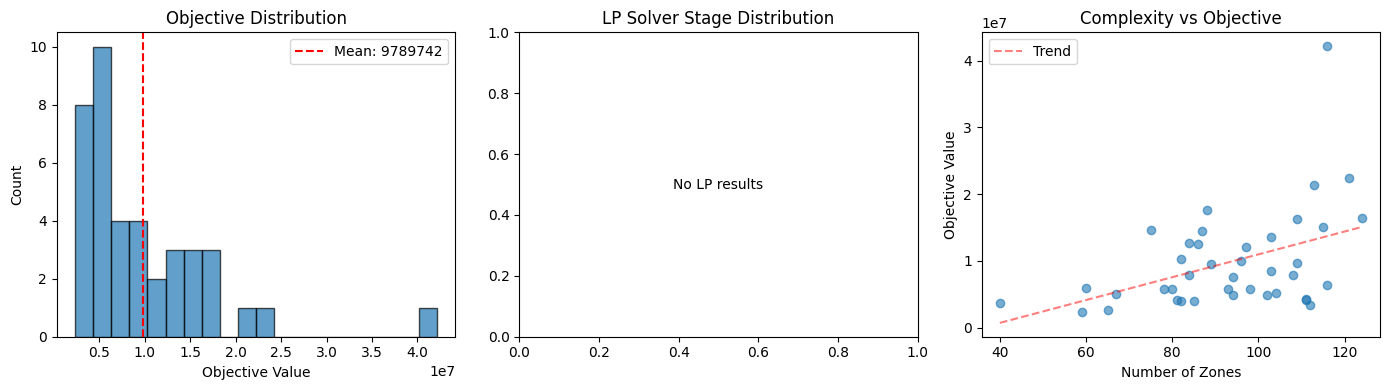

✓ Analysis saved to /content/drive/MyDrive/benchmark/outputs/pipeline_eval/pipeline_eval_analysis.png


In [36]:
# Visualization: Results analysis
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1. Objective distribution
objs = [r['best_obj'] for r in all_results if r['best_obj'] < float('inf')]
if objs:
    axes[0].hist(objs, bins=20, edgecolor='black', alpha=0.7)
    axes[0].axvline(np.mean(objs), color='red', linestyle='--', label=f'Mean: {np.mean(objs):.0f}')
    axes[0].set_xlabel('Objective Value')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Objective Distribution')
    axes[0].legend()
else:
    axes[0].text(0.5, 0.5, 'No valid objectives', ha='center', va='center', transform=axes[0].transAxes)
    axes[0].set_title('Objective Distribution')

# 2. Stage distribution (pie chart) - extract from LP results
stages = {'hard_fix': 0, 'repair_20': 0, 'repair_100': 0, 'full_soft': 0, 'error': 0}
for r in all_results:
    for lp_res in r.get('lp_results', []):
        if isinstance(lp_res, dict):
            stages['error'] += 1
        else:
            stage = getattr(lp_res, 'stage_used', None) or getattr(lp_res, 'solve_stage', 'unknown')
            if stage in stages:
                stages[stage] += 1

# Filter out zero values for pie chart
stages_filtered = {k: v for k, v in stages.items() if v > 0}
if stages_filtered:
    axes[1].pie(stages_filtered.values(), labels=stages_filtered.keys(), autopct='%1.1f%%')
    axes[1].set_title('LP Solver Stage Distribution')
else:
    axes[1].text(0.5, 0.5, 'No LP results', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('LP Solver Stage Distribution')

# 3. Scenario complexity (zones vs objective)
zones_list, objs_list = [], []
for r in all_results:
    if r['best_obj'] < float('inf'):
        zones_list.append(r['n_zones'])
        objs_list.append(r['best_obj'])

if zones_list and objs_list:
    axes[2].scatter(zones_list, objs_list, alpha=0.6)
    axes[2].set_xlabel('Number of Zones')
    axes[2].set_ylabel('Objective Value')
    axes[2].set_title('Complexity vs Objective')
    # Add trend line
    if len(zones_list) > 2:
        z = np.polyfit(zones_list, objs_list, 1)
        p = np.poly1d(z)
        x_line = np.linspace(min(zones_list), max(zones_list), 100)
        axes[2].plot(x_line, p(x_line), 'r--', alpha=0.5, label=f'Trend')
        axes[2].legend()
else:
    axes[2].text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_title('Complexity vs Objective')

plt.tight_layout()
plt.savefig(CONFIG['output_dir'] / 'pipeline_eval_analysis.png', dpi=150)
plt.show()
print(f"✓ Analysis saved to {CONFIG['output_dir'] / 'pipeline_eval_analysis.png'}")

In [21]:
# Export detailed results to CSV
results_data = []
for r in all_results:
    row = {'scenario_id': r['scenario_id'], 'best_objective': r['best_obj'], 'n_samples': len(r['samples'])}
    if r['lp_results']:
        best_lp = min(r['lp_results'], key=lambda x: x.objective_value if hasattr(x, 'objective_value') else float('inf'))
        if hasattr(best_lp, 'stage_used'):
            row['stage'] = best_lp.stage_used.value if hasattr(best_lp.stage_used, 'value') else str(best_lp.stage_used)
        if hasattr(best_lp, 'slack_used'): row['slack_mwh'] = best_lp.slack_used
        if hasattr(best_lp, 'n_flips'): row['n_flips'] = best_lp.n_flips
        if hasattr(best_lp, 'solve_time'): row['solve_time_s'] = best_lp.solve_time
    results_data.append(row)

df = pd.DataFrame(results_data)
csv_path = CONFIG['output_dir'] / 'pipeline_eval_results.csv'
df.to_csv(csv_path, index=False)
print(f"✓ Results exported to {csv_path}")
display(df.head(40))

✓ Results exported to /content/drive/MyDrive/benchmark/outputs/pipeline_eval/pipeline_eval_results.csv


,scenario_id,best_objective,n_samples,stage,slack_mwh,n_flips,solve_time_s
0,scenario_00007,1.513477e+07,5,hard_fix,0.000000,0,14.154966
1,scenario_00017,4.108019e+06,5,full_soft,0.000000,472,51.540087
2,scenario_00042,4.076916e+06,5,full_soft,48.186622,367,68.640956
3,scenario_00124,5.832728e+06,5,full_soft,2.583645,413,56.236731
4,scenario_00129,2.249853e+07,5,full_soft,1872.907976,800,80.579537
5,scenario_00295,1.450029e+07,5,repair_100,45.511248,0,31.009822
6,scenario_00313,7.520992e+06,5,hard_fix,0.000000,0,11.603957
7,scenario_00375,9.994877e+06,5,repair_100,223.016881,4,34.532400
8,scenario_00476,4.933542e+06,5,full_soft,0.370529,540,59.090657
9,scenario_00564,9.741656e+06,5,repair_20,0.000000,0,27.337932


from matplotlib import pyplot as plt
_df_0['best_objective'].plot(kind='hist', bins=20, title='best_objective')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['slack_mwh'].plot(kind='hist', bins=20, title='slack_mwh')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['n_flips'].plot(kind='hist', bins=20, title='n_flips')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['solve_time_s'].plot(kind='hist', bins=20, title='solve_time_s')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('stage').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='best_objective', y='slack_mwh', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='slack_mwh', y='n_flips', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='n_flips', y='solve_time_s', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['n_samples']
  ys = series['best_objective']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('n_samples', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('stage')):
  _plot_series(series, series_name, i)
  fig.legend(title='stage', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('n_samples')
_ = plt.ylabel('best_objective')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['n_samples']
  ys = series['slack_mwh']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('n_samples', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('stage')):
  _plot_series(series, series_name, i)
  fig.legend(title='stage', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('n_samples')
_ = plt.ylabel('slack_mwh')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['n_samples']
  ys = series['n_flips']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('n_samples', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('stage')):
  _plot_series(series, series_name, i)
  fig.legend(title='stage', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('n_samples')
_ = plt.ylabel('n_flips')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['n_samples']
  ys = series['solve_time_s']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('n_samples', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('stage')):
  _plot_series(series, series_name, i)
  fig.legend(title='stage', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('n_samples')
_ = plt.ylabel('solve_time_s')

from matplotlib import pyplot as plt
_df_12['best_objective'].plot(kind='line', figsize=(8, 4), title='best_objective')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['slack_mwh'].plot(kind='line', figsize=(8, 4), title='slack_mwh')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['n_flips'].plot(kind='line', figsize=(8, 4), title='n_flips')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['solve_time_s'].plot(kind='line', figsize=(8, 4), title='solve_time_s')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['stage'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='best_objective', y='stage', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['stage'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='slack_mwh', y='stage', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['stage'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='n_flips', y='stage', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['stage'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='solve_time_s', y='stage', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# 15. Results Analysis

In [68]:
# =============================================================================
# COMPREHENSIVE ANALYSIS: LP Worker vs MILP Ground Truth
# =============================================================================
# For research paper: distributions, correlations, optimality gaps, cost breakdown
# =============================================================================

import scipy.stats as stats
from collections import defaultdict

print("="*80)
print("COMPREHENSIVE ANALYSIS: GNN+EBM+Decoder Pipeline vs MILP Ground Truth")
print("="*80)

def clean_stage(s):
    s_str = str(s)
    if 'SolveStage.' in s_str:
        return s_str.replace('SolveStage.', '').lower()
    return s_str.lower()

# 1. Load MILP ground truth reports
reports_dir = CONFIG['eval_reports_dir']
milp_results = {}

for r in all_results:
    sc_id = r['scenario_id']
    report_path = reports_dir / f"{sc_id}.json"
    if report_path.exists():
        with open(report_path, 'r') as f:
            milp_results[sc_id] = json.load(f)

print(f"\n✓ Loaded {len(milp_results)} MILP reports for comparison")

# 2. Build comparison dataframe
comparison_data = []

for r in all_results:
    sc_id = r['scenario_id']
    if sc_id not in milp_results:
        continue

    milp = milp_results[sc_id]
    milp_obj = milp.get('mip', {}).get('objective', float('inf'))
    milp_lp_obj = milp.get('lp', {}).get('objective', float('inf'))
    milp_status = milp.get('mip', {}).get('status', 'unknown')
    milp_time = milp.get('mip', {}).get('solve_seconds', 0)

    # Get best LP worker result
    pipeline_obj = r['best_obj'] if r['best_obj'] < float('inf') else None

    # Get stage info from best result
    best_idx = r['best_sample_idx']
    stage = 'N/A'
    if best_idx >= 0 and best_idx < len(r['lp_results']):
        lp_res = r['lp_results'][best_idx]
        if not isinstance(lp_res, dict):
            stage = clean_stage(getattr(lp_res, 'stage_used', 'unknown'))


    # Cost components from MILP
    costs = milp.get('cost_components', {})

    comparison_data.append({
        'scenario_id': sc_id,
        'n_zones': r['n_zones'],
        'milp_obj': milp_obj,
        'milp_lp_obj': milp_lp_obj,
        'milp_status': milp_status,
        'milp_time': milp_time,
        'pipeline_obj': pipeline_obj,
        'stage': stage,
        'n_samples': len(r['samples']),
        # MILP cost components
        'thermal_fuel': costs.get('thermal_fuel', 0),
        'nuclear_fuel': costs.get('nuclear_fuel', 0),
        'battery_cycle': costs.get('battery_cycle', 0),
        'solar_spill': costs.get('solar_spill', 0),
        'wind_spill': costs.get('wind_spill', 0),
        'unserved_energy': costs.get('unserved_energy', 0),
        'demand_response': costs.get('demand_response', 0),
    })

df = pd.DataFrame(comparison_data)
df['gap_vs_milp'] = (df['pipeline_obj'] - df['milp_obj']) / df['milp_obj'] * 100  # %
df['gap_vs_lp'] = (df['pipeline_obj'] - df['milp_lp_obj']) / df['milp_lp_obj'] * 100  # %

print(f"\n✓ Built comparison table: {len(df)} scenarios")
print(f"  Valid pipeline solutions: {df['pipeline_obj'].notna().sum()}")
print(f"  MILP optimal: {(df['milp_status'] == 'ok').sum()}")
print(f"  MILP aborted (timeout): {(df['milp_status'] == 'aborted').sum()}")

COMPREHENSIVE ANALYSIS: GNN+EBM+Decoder Pipeline vs MILP Ground Truth

✓ Loaded 40 MILP reports for comparison
0       hard_fix
1      full_soft
2      full_soft
3      full_soft
4      full_soft
5     repair_100
6       hard_fix
7     repair_100
8      full_soft
9      repair_20
10     full_soft
11     full_soft
12     repair_20
13     full_soft
14     full_soft
15     full_soft
16     full_soft
17     repair_20
18      hard_fix
19     full_soft
20     full_soft
21      hard_fix
22     full_soft
23     full_soft
24     full_soft
25     full_soft
26     full_soft
27     full_soft
28     full_soft
29     full_soft
30     full_soft
31    repair_100
32     repair_20
33     full_soft
34    repair_100
35      hard_fix
36     full_soft
37     full_soft
38     full_soft
39     repair_20
Name: stage, dtype: object

✓ Built comparison table: 40 scenarios
  Valid pipeline solutions: 40
  MILP optimal: 0
  MILP aborted (timeout): 40


In [69]:
# =============================================================================
# 3. OPTIMALITY GAP ANALYSIS
# =============================================================================

df_valid = df[df['pipeline_obj'].notna() & (df['milp_obj'] < 1e10)].copy()

print("\n" + "="*80)
print("OPTIMALITY GAP ANALYSIS")
print("="*80)

# Summary statistics
print("\n📊 Gap vs MILP Solution (%):")
print(f"   Mean:   {df_valid['gap_vs_milp'].mean():+.2f}%")
print(f"   Median: {df_valid['gap_vs_milp'].median():+.2f}%")
print(f"   Std:    {df_valid['gap_vs_milp'].std():.2f}%")
print(f"   Min:    {df_valid['gap_vs_milp'].min():+.2f}%")
print(f"   Max:    {df_valid['gap_vs_milp'].max():+.2f}%")

print("\n📊 Gap vs LP Relaxation (%):")
print(f"   Mean:   {df_valid['gap_vs_lp'].mean():+.2f}%")
print(f"   Median: {df_valid['gap_vs_lp'].median():+.2f}%")
print(f"   Std:    {df_valid['gap_vs_lp'].std():.2f}%")

# Breakdown by MILP status
print("\n📊 Gap by MILP Solve Status:")
for status in df_valid['milp_status'].unique():
    subset = df_valid[df_valid['milp_status'] == status]
    print(f"   {status}: n={len(subset)}, mean_gap={subset['gap_vs_milp'].mean():+.2f}%, median={subset['gap_vs_milp'].median():+.2f}%")

# Breakdown by pipeline stage
print("\n📊 Gap by Pipeline Stage:")
for stage in df_valid['stage'].unique():
    subset = df_valid[df_valid['stage'] == stage]
    print(f"   {stage}: n={len(subset)}, mean_gap={subset['gap_vs_milp'].mean():+.2f}%, median={subset['gap_vs_milp'].median():+.2f}%")

# Percentiles
print("\n📊 Gap Percentiles (vs MILP):")
for p in [10, 25, 50, 75, 90, 95, 99]:
    print(f"   P{p}: {np.percentile(df_valid['gap_vs_milp'], p):+.2f}%")

# Count scenarios beating MILP (better objective)
beating_milp = (df_valid['gap_vs_milp'] < 0).sum()
within_1pct = (df_valid['gap_vs_milp'].abs() < 1).sum()
within_5pct = (df_valid['gap_vs_milp'].abs() < 5).sum()
print(f"\n📊 Quality Thresholds:")
print(f"   Beating MILP (gap < 0%): {beating_milp} ({100*beating_milp/len(df_valid):.1f}%)")
print(f"   Within 1% of MILP: {within_1pct} ({100*within_1pct/len(df_valid):.1f}%)")
print(f"   Within 5% of MILP: {within_5pct} ({100*within_5pct/len(df_valid):.1f}%)")


OPTIMALITY GAP ANALYSIS

📊 Gap vs MILP Solution (%):
   Mean:   +55.60%
   Median: -0.05%
   Std:    83.19%
   Min:    -3.87%
   Max:    +266.77%

📊 Gap vs LP Relaxation (%):
   Mean:   +57.91%
   Median: +0.45%
   Std:    84.38%

📊 Gap by MILP Solve Status:
   aborted: n=40, mean_gap=+55.60%, median=-0.05%

📊 Gap by Pipeline Stage:
   hard_fix: n=5, mean_gap=+163.62%, median=+158.53%
   full_soft: n=26, mean_gap=-0.89%, median=-0.68%
   repair_100: n=4, mean_gap=+166.13%, median=+143.57%
   repair_20: n=5, mean_gap=+152.88%, median=+146.34%

📊 Gap Percentiles (vs MILP):
   P10: -1.74%
   P25: -0.97%
   P50: -0.05%
   P75: +130.44%
   P90: +172.67%
   P95: +212.88%
   P99: +249.21%

📊 Quality Thresholds:
   Beating MILP (gap < 0%): 21 (52.5%)
   Within 1% of MILP: 16 (40.0%)
   Within 5% of MILP: 26 (65.0%)


/tmp/ipython-input-768103380.py:76: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_stage, labels=stages_present, patch_artist=True)


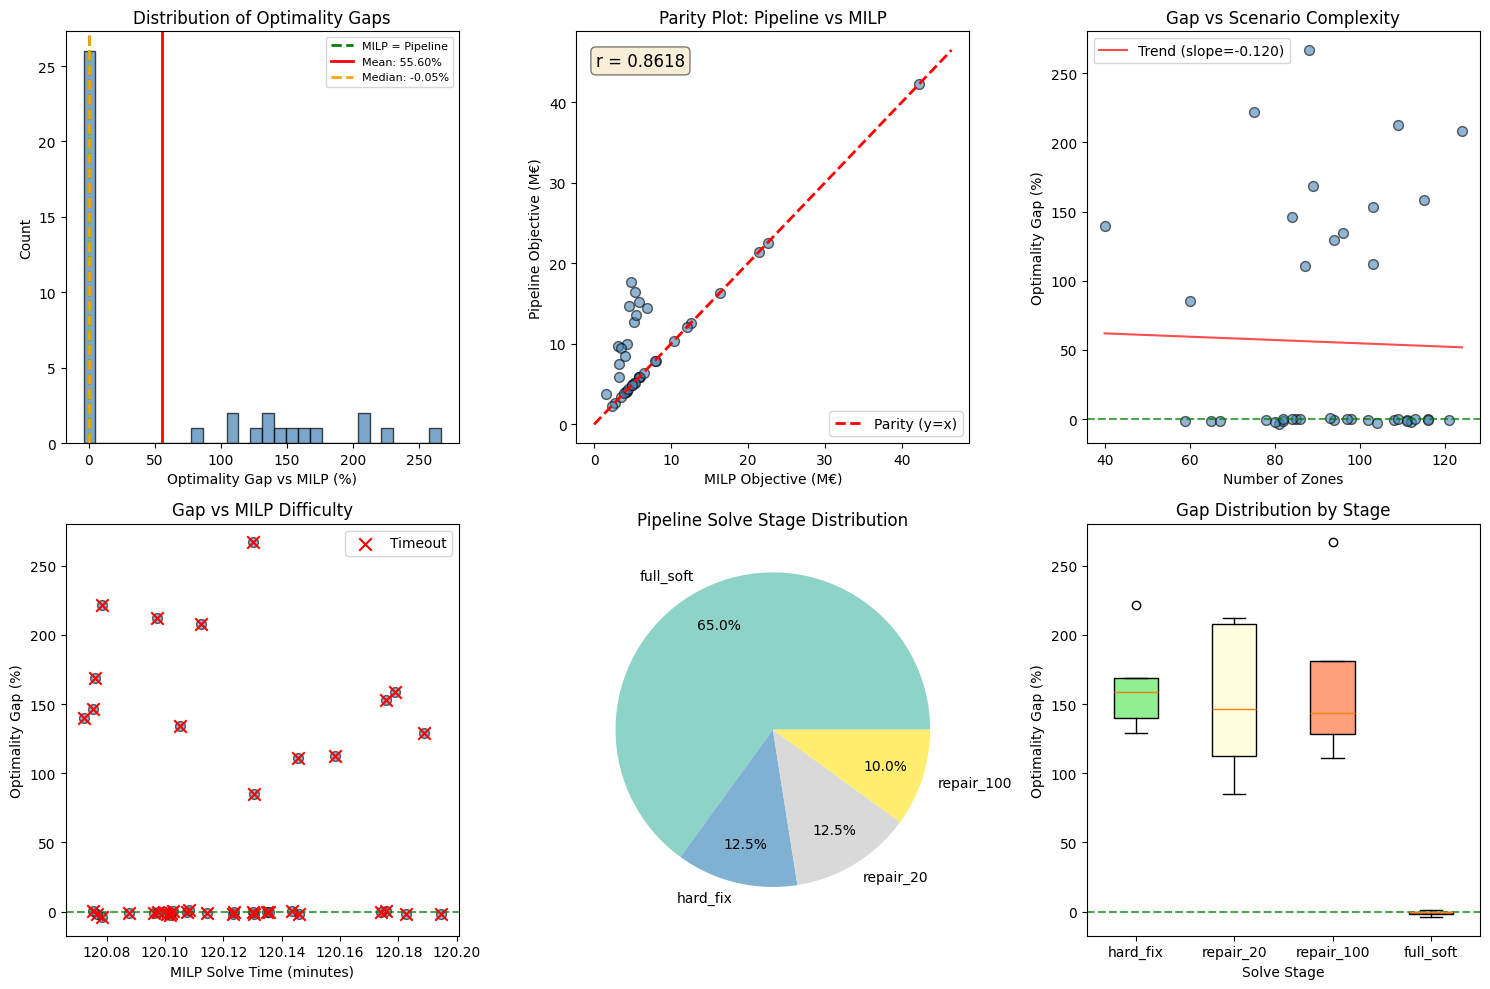

✓ Saved to /content/drive/MyDrive/benchmark/outputs/pipeline_eval/gap_analysis_detailed.png


In [70]:
# =============================================================================
# 4. VISUALIZATION: DISTRIBUTIONS AND CORRELATIONS
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 4.1 Gap Distribution Histogram
ax = axes[0, 0]
gaps = df_valid['gap_vs_milp'].dropna()
ax.hist(gaps, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(0, color='green', linestyle='--', linewidth=2, label='MILP = Pipeline')
ax.axvline(gaps.mean(), color='red', linestyle='-', linewidth=2, label=f'Mean: {gaps.mean():.2f}%')
ax.axvline(gaps.median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {gaps.median():.2f}%')
ax.set_xlabel('Optimality Gap vs MILP (%)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Optimality Gaps')
ax.legend(fontsize=8)

# 4.2 Pipeline vs MILP Scatter (Parity Plot)
ax = axes[0, 1]
valid_both = df_valid[df_valid['pipeline_obj'].notna() & (df_valid['milp_obj'] < 1e10)]
ax.scatter(valid_both['milp_obj']/1e6, valid_both['pipeline_obj']/1e6, alpha=0.6, c='steelblue', edgecolor='k', s=50)
max_val = max(valid_both['milp_obj'].max(), valid_both['pipeline_obj'].max()) / 1e6 * 1.1
ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Parity (y=x)')
ax.set_xlabel('MILP Objective (M€)')
ax.set_ylabel('Pipeline Objective (M€)')
ax.set_title('Parity Plot: Pipeline vs MILP')
ax.legend()
# Correlation
corr = valid_both['milp_obj'].corr(valid_both['pipeline_obj'])
ax.text(0.05, 0.95, f'r = {corr:.4f}', transform=ax.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4.3 Gap vs Scenario Complexity (Zones)
ax = axes[0, 2]
ax.scatter(df_valid['n_zones'], df_valid['gap_vs_milp'], alpha=0.6, c='steelblue', edgecolor='k', s=50)
ax.axhline(0, color='green', linestyle='--', alpha=0.7)
ax.set_xlabel('Number of Zones')
ax.set_ylabel('Optimality Gap (%)')
ax.set_title('Gap vs Scenario Complexity')
# Trend line
if len(df_valid) > 2:
    z = np.polyfit(df_valid['n_zones'], df_valid['gap_vs_milp'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_valid['n_zones'].min(), df_valid['n_zones'].max(), 100)
    ax.plot(x_line, p(x_line), 'r-', alpha=0.7, label=f'Trend (slope={z[0]:.3f})')
    ax.legend()

# 4.4 Gap vs MILP Solve Time
ax = axes[1, 0]
ax.scatter(df_valid['milp_time']/60, df_valid['gap_vs_milp'], alpha=0.6, c='steelblue', edgecolor='k', s=50)
ax.axhline(0, color='green', linestyle='--', alpha=0.7)
ax.set_xlabel('MILP Solve Time (minutes)')
ax.set_ylabel('Optimality Gap (%)')
ax.set_title('Gap vs MILP Difficulty')
# Highlight timeouts (>7200s = 2h)
timeouts = df_valid[df_valid['milp_time'] > 7000]
if len(timeouts) > 0:
    ax.scatter(timeouts['milp_time']/60, timeouts['gap_vs_milp'], c='red', s=80, marker='x', label='Timeout', zorder=5)
    ax.legend()

# 4.5 Stage Distribution (Pie)
ax = axes[1, 1]
stage_counts = df_valid['stage'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(stage_counts)))
wedges, texts, autotexts = ax.pie(stage_counts.values, labels=stage_counts.index, autopct='%1.1f%%',
                                   colors=colors, pctdistance=0.75)
ax.set_title('Pipeline Solve Stage Distribution')

# 4.6 Boxplot by Stage
ax = axes[1, 2]
stages_order = ['hard_fix', 'repair_20', 'repair_100', 'full_soft']
stages_present = [s for s in stages_order if s in df_valid['stage'].values]
if stages_present:
    data_by_stage = [df_valid[df_valid['stage'] == s]['gap_vs_milp'].values for s in stages_present]
    bp = ax.boxplot(data_by_stage, labels=stages_present, patch_artist=True)
    colors = ['lightgreen', 'lightyellow', 'lightsalmon', 'lightcoral'][:len(stages_present)]
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
ax.axhline(0, color='green', linestyle='--', alpha=0.7)
ax.set_xlabel('Solve Stage')
ax.set_ylabel('Optimality Gap (%)')
ax.set_title('Gap Distribution by Stage')

plt.tight_layout()
plt.savefig(CONFIG['output_dir'] / 'gap_analysis_detailed.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved to {CONFIG['output_dir'] / 'gap_analysis_detailed.png'}")

In [71]:
# =============================================================================
# 5. STATISTICAL TESTS
# =============================================================================

print("\n" + "="*80)
print("STATISTICAL ANALYSIS")
print("="*80)

# 5.1 Normality test on gaps
gaps = df_valid['gap_vs_milp'].dropna()
if len(gaps) >= 8:
    stat, p_shapiro = stats.shapiro(gaps)
    print(f"\n📊 Shapiro-Wilk Normality Test:")
    print(f"   Statistic: {stat:.4f}, p-value: {p_shapiro:.4e}")
    print(f"   → {'Normal' if p_shapiro > 0.05 else 'Non-normal'} distribution (α=0.05)")

# 5.2 One-sample t-test: Is mean gap significantly different from 0?
if len(gaps) >= 3:
    t_stat, p_ttest = stats.ttest_1samp(gaps, 0)
    print(f"\n📊 One-sample t-test (H0: mean gap = 0):")
    print(f"   t-statistic: {t_stat:.4f}, p-value: {p_ttest:.4e}")
    print(f"   → Mean gap is {'significantly' if p_ttest < 0.05 else 'not significantly'} different from 0")

# 5.3 Wilcoxon signed-rank test (non-parametric)
if len(gaps) >= 3:
    try:
        w_stat, p_wilcox = stats.wilcoxon(gaps)
        print(f"\n📊 Wilcoxon Signed-Rank Test (H0: median gap = 0):")
        print(f"   Statistic: {w_stat:.4f}, p-value: {p_wilcox:.4e}")
        print(f"   → Median gap is {'significantly' if p_wilcox < 0.05 else 'not significantly'} different from 0")
    except:
        pass

# 5.4 Correlation analysis
print(f"\n📊 Correlation Analysis:")
corr_zones = df_valid['n_zones'].corr(df_valid['gap_vs_milp'])
corr_time = df_valid['milp_time'].corr(df_valid['gap_vs_milp'])
corr_obj = df_valid['milp_obj'].corr(df_valid['gap_vs_milp'])
print(f"   Gap vs Zones:     r = {corr_zones:+.4f}")
print(f"   Gap vs MILP Time: r = {corr_time:+.4f}")
print(f"   Gap vs MILP Obj:  r = {corr_obj:+.4f}")

# Spearman correlations (rank-based, more robust)
print(f"\n📊 Spearman Rank Correlations:")
rho_zones, p_zones = stats.spearmanr(df_valid['n_zones'], df_valid['gap_vs_milp'])
rho_time, p_time = stats.spearmanr(df_valid['milp_time'], df_valid['gap_vs_milp'])
print(f"   Gap vs Zones:     ρ = {rho_zones:+.4f} (p={p_zones:.4e})")
print(f"   Gap vs MILP Time: ρ = {rho_time:+.4f} (p={p_time:.4e})")

# 5.5 Compare stages using Kruskal-Wallis (non-parametric ANOVA)
stages_data = {s: df_valid[df_valid['stage'] == s]['gap_vs_milp'].values
               for s in df_valid['stage'].unique() if len(df_valid[df_valid['stage'] == s]) >= 2}
if len(stages_data) >= 2:
    kw_stat, p_kw = stats.kruskal(*stages_data.values())
    print(f"\n📊 Kruskal-Wallis Test (Gap difference between stages):")
    print(f"   H-statistic: {kw_stat:.4f}, p-value: {p_kw:.4e}")
    print(f"   → Stages have {'significantly' if p_kw < 0.05 else 'no significantly'} different gap distributions")


STATISTICAL ANALYSIS

📊 Shapiro-Wilk Normality Test:
   Statistic: 0.7091, p-value: 1.3798e-07
   → Non-normal distribution (α=0.05)

📊 One-sample t-test (H0: mean gap = 0):
   t-statistic: 4.2268, p-value: 1.3818e-04
   → Mean gap is significantly different from 0

📊 Wilcoxon Signed-Rank Test (H0: median gap = 0):
   Statistic: 315.0000, p-value: 2.0641e-01
   → Median gap is not significantly different from 0

📊 Correlation Analysis:
   Gap vs Zones:     r = -0.0272
   Gap vs MILP Time: r = -0.0391
   Gap vs MILP Obj:  r = -0.2786

📊 Spearman Rank Correlations:
   Gap vs Zones:     ρ = +0.0768 (p=6.3780e-01)
   Gap vs MILP Time: ρ = -0.0417 (p=7.9858e-01)

📊 Kruskal-Wallis Test (Gap difference between stages):
   H-statistic: 26.6835, p-value: 6.8589e-06
   → Stages have significantly different gap distributions



COST COMPONENT ANALYSIS (MILP Ground Truth)

📊 Cost Component Statistics (€):
----------------------------------------------------------------------
Component                    Mean          Std          Min          Max
----------------------------------------------------------------------
thermal_fuel            2,339,524    1,467,052      440,919    7,681,591
nuclear_fuel            1,089,470      382,879      176,620    1,838,801
battery_cycle             574,225      400,956       90,552    1,604,214
solar_spill               300,268      198,145        9,981      974,867
wind_spill                412,634      277,525        6,853    1,160,799
unserved_energy         2,457,976    5,914,692            0   31,096,241
----------------------------------------------------------------------

📊 Cost Breakdown (% of Total):
   thermal_fuel        :  32.61%
   nuclear_fuel        :  15.19%
   battery_cycle       :   8.00%
   solar_spill         :   4.19%
   wind_spill          :   5.75%


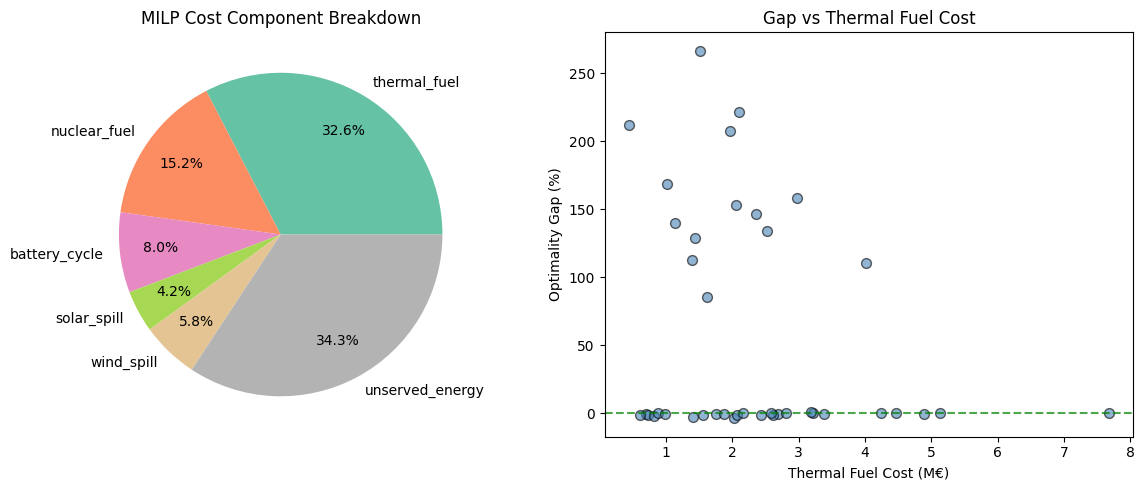

In [72]:
# =============================================================================
# 6. COST COMPONENT ANALYSIS (MILP Ground Truth Breakdown)
# =============================================================================

print("\n" + "="*80)
print("COST COMPONENT ANALYSIS (MILP Ground Truth)")
print("="*80)

cost_cols = ['thermal_fuel', 'nuclear_fuel', 'battery_cycle', 'solar_spill', 'wind_spill', 'unserved_energy']

# Summary table
print("\n📊 Cost Component Statistics (€):")
print("-" * 70)
print(f"{'Component':<20} {'Mean':>12} {'Std':>12} {'Min':>12} {'Max':>12}")
print("-" * 70)
for col in cost_cols:
    if col in df_valid.columns:
        vals = df_valid[col]
        print(f"{col:<20} {vals.mean():>12,.0f} {vals.std():>12,.0f} {vals.min():>12,.0f} {vals.max():>12,.0f}")
print("-" * 70)

# Percentage breakdown
total_cost = df_valid[cost_cols].sum().sum()
print(f"\n📊 Cost Breakdown (% of Total):")
for col in cost_cols:
    pct = df_valid[col].sum() / total_cost * 100
    print(f"   {col:<20}: {pct:>6.2f}%")

# Correlation between cost components and gap
print(f"\n📊 Correlation: Cost Components vs Optimality Gap:")
for col in cost_cols:
    if df_valid[col].std() > 0:
        corr = df_valid[col].corr(df_valid['gap_vs_milp'])
        print(f"   {col:<20}: r = {corr:+.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Cost breakdown pie
ax = axes[0]
cost_sums = df_valid[cost_cols].sum()
cost_sums = cost_sums[cost_sums > 0]
colors = plt.cm.Set2(np.linspace(0, 1, len(cost_sums)))
wedges, texts, autotexts = ax.pie(cost_sums.values, labels=cost_sums.index, autopct='%1.1f%%',
                                   colors=colors, pctdistance=0.75)
ax.set_title('MILP Cost Component Breakdown')

# Gap vs Thermal cost
ax = axes[1]
ax.scatter(df_valid['thermal_fuel']/1e6, df_valid['gap_vs_milp'], alpha=0.6, c='steelblue', edgecolor='k', s=50)
ax.set_xlabel('Thermal Fuel Cost (M€)')
ax.set_ylabel('Optimality Gap (%)')
ax.set_title('Gap vs Thermal Fuel Cost')
ax.axhline(0, color='green', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(CONFIG['output_dir'] / 'cost_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [73]:
# =============================================================================
# 7. PAPER-READY SUMMARY TABLES
# =============================================================================

print("\n" + "="*80)
print("PAPER-READY SUMMARY TABLES")
print("="*80)

# Table 1: Overall Performance
print("\n" + "-"*70)
print("TABLE 1: Overall Pipeline Performance")
print("-"*70)
table1_data = {
    'Metric': [
        'Total Scenarios',
        'Valid Solutions',
        'Success Rate (%)',
        'Mean Gap vs MILP (%)',
        'Median Gap vs MILP (%)',
        'Std Gap (%)',
        '% Within 1% of MILP',
        '% Within 5% of MILP',
        '% Beating MILP',
    ],
    'Value': [
        len(df),
        len(df_valid),
        f"{100*len(df_valid)/len(df):.1f}",
        f"{df_valid['gap_vs_milp'].mean():.2f}",
        f"{df_valid['gap_vs_milp'].median():.2f}",
        f"{df_valid['gap_vs_milp'].std():.2f}",
        f"{100*(df_valid['gap_vs_milp'].abs() < 1).sum()/len(df_valid):.1f}",
        f"{100*(df_valid['gap_vs_milp'].abs() < 5).sum()/len(df_valid):.1f}",
        f"{100*(df_valid['gap_vs_milp'] < 0).sum()/len(df_valid):.1f}",
    ]
}
table1 = pd.DataFrame(table1_data)
print(table1.to_string(index=False))

# Table 2: Performance by Solve Stage
print("\n" + "-"*70)
print("TABLE 2: Performance by LP Solve Stage")
print("-"*70)
table2_rows = []
for stage in ['hard_fix', 'repair_20', 'repair_100', 'full_soft']:
    subset = df_valid[df_valid['stage'] == stage]
    if len(subset) > 0:
        table2_rows.append({
            'Stage': stage,
            'Count': len(subset),
            '% of Total': f"{100*len(subset)/len(df_valid):.1f}",
            'Mean Gap (%)': f"{subset['gap_vs_milp'].mean():.2f}",
            'Median Gap (%)': f"{subset['gap_vs_milp'].median():.2f}",
            'Std Gap (%)': f"{subset['gap_vs_milp'].std():.2f}",
        })
table2 = pd.DataFrame(table2_rows)
print(table2.to_string(index=False))

# Table 3: Performance by Scenario Complexity
print("\n" + "-"*70)
print("TABLE 3: Performance by Scenario Complexity (Zone Count)")
print("-"*70)
# Create complexity bins
df_valid['complexity_bin'] = pd.cut(df_valid['n_zones'], bins=[0, 20, 40, 60, 80, 200],
                                     labels=['1-20', '21-40', '41-60', '61-80', '81+'])
table3_rows = []
for bin_label in ['1-20', '21-40', '41-60', '61-80', '81+']:
    subset = df_valid[df_valid['complexity_bin'] == bin_label]
    if len(subset) > 0:
        table3_rows.append({
            'Zones': bin_label,
            'Count': len(subset),
            'Mean Gap (%)': f"{subset['gap_vs_milp'].mean():.2f}",
            'Median Gap (%)': f"{subset['gap_vs_milp'].median():.2f}",
            'Std Gap (%)': f"{subset['gap_vs_milp'].std():.2f}",
        })
table3 = pd.DataFrame(table3_rows)
print(table3.to_string(index=False))

# Table 4: Comparison with MILP solve time
print("\n" + "-"*70)
print("TABLE 4: Performance vs MILP Difficulty")
print("-"*70)
df_valid['time_bin'] = pd.cut(df_valid['milp_time']/60, bins=[0, 10, 60, 120, 10000],
                               labels=['<10min', '10-60min', '1-2h', '>2h (timeout)'])
table4_rows = []
for bin_label in ['<10min', '10-60min', '1-2h', '>2h (timeout)']:
    subset = df_valid[df_valid['time_bin'] == bin_label]
    if len(subset) > 0:
        table4_rows.append({
            'MILP Time': bin_label,
            'Count': len(subset),
            'Mean Gap (%)': f"{subset['gap_vs_milp'].mean():.2f}",
            'Median Gap (%)': f"{subset['gap_vs_milp'].median():.2f}",
            '% Beating MILP': f"{100*(subset['gap_vs_milp'] < 0).sum()/len(subset):.1f}",
        })
table4 = pd.DataFrame(table4_rows)
print(table4.to_string(index=False))


PAPER-READY SUMMARY TABLES

----------------------------------------------------------------------
TABLE 1: Overall Pipeline Performance
----------------------------------------------------------------------
                Metric Value
       Total Scenarios    40
       Valid Solutions    40
      Success Rate (%) 100.0
  Mean Gap vs MILP (%) 55.60
Median Gap vs MILP (%) -0.05
           Std Gap (%) 83.19
   % Within 1% of MILP  40.0
   % Within 5% of MILP  65.0
        % Beating MILP  52.5

----------------------------------------------------------------------
TABLE 2: Performance by LP Solve Stage
----------------------------------------------------------------------
     Stage  Count % of Total Mean Gap (%) Median Gap (%) Std Gap (%)
  hard_fix      5       12.5       163.62         158.53       35.99
 repair_20      5       12.5       152.88         146.34       56.61
repair_100      4       10.0       166.13         143.57       69.30
 full_soft     26       65.0        -0.89  

In [74]:
# =============================================================================
# 8. DECODER QUALITY ANALYSIS
# =============================================================================

print("\n" + "="*80)
print("DECODER QUALITY ANALYSIS")
print("="*80)

# Analyze decoded plans quality
decoder_stats = {
    'total_unserved_mwh': 0,
    'total_curtailed_mwh': 0,
    'scenarios_with_unserved': 0,
    'scenarios_with_curtailment': 0,
    'avg_battery_utilization': [],
    'avg_thermal_utilization': [],
    'avg_nuclear_utilization': [],
}

for r in all_results:
    if len(r['decoded_plans']) == 0:
        continue

    # Use best plan or first plan
    best_idx = max(0, r['best_sample_idx']) if r['best_sample_idx'] >= 0 else 0
    if best_idx < len(r['decoded_plans']):
        plan = r['decoded_plans'][best_idx]

        unserved = plan.unserved_energy.sum().item()
        curtailed = plan.curtailment.sum().item()

        decoder_stats['total_unserved_mwh'] += unserved
        decoder_stats['total_curtailed_mwh'] += curtailed

        if unserved > 1e-3:
            decoder_stats['scenarios_with_unserved'] += 1
        if curtailed > 1e-3:
            decoder_stats['scenarios_with_curtailment'] += 1

print(f"\n📊 Decoder Feasibility Stats:")
print(f"   Total Unserved Energy: {decoder_stats['total_unserved_mwh']/1000:.2f} GWh")
print(f"   Total Curtailment: {decoder_stats['total_curtailed_mwh']/1000:.2f} GWh")
print(f"   Scenarios with Unserved: {decoder_stats['scenarios_with_unserved']} / {len(all_results)}")
print(f"   Scenarios with Curtailment: {decoder_stats['scenarios_with_curtailment']} / {len(all_results)}")

# Compare pipeline unserved vs MILP unserved
milp_unserved = df_valid['unserved_energy'].sum()
print(f"\n📊 Unserved Energy Comparison:")
print(f"   MILP Total Unserved: {milp_unserved/1000:.2f} GWh")
print(f"   Pipeline Total Unserved: {decoder_stats['total_unserved_mwh']/1000:.2f} GWh")


DECODER QUALITY ANALYSIS

📊 Decoder Feasibility Stats:
   Total Unserved Energy: 0.00 GWh
   Total Curtailment: 5292.44 GWh
   Scenarios with Unserved: 0 / 40
   Scenarios with Curtailment: 40 / 40

📊 Unserved Energy Comparison:
   MILP Total Unserved: 98319.03 GWh
   Pipeline Total Unserved: 0.00 GWh


In [75]:
# =============================================================================
# 9. EXPORT DATA & FINAL SUMMARY
# =============================================================================

# Export comparison dataframe to CSV
csv_path = CONFIG['output_dir'] / 'pipeline_vs_milp_comparison.csv'
df.to_csv(csv_path, index=False)
print(f"✓ Exported comparison data to {csv_path}")

# Export summary statistics to JSON (convert keys to strings for JSON compatibility)
stage_dist = {str(k): int(v) for k, v in df_valid['stage'].value_counts().items()}

summary_stats = {
    'experiment_info': {
        'n_scenarios': int(len(df)),
        'n_valid': int(len(df_valid)),
        'n_samples_per_scenario': int(CONFIG['n_samples']),
        'langevin_steps': int(CONFIG['langevin_steps']),
    },
    'optimality_gap': {
        'mean_pct': float(df_valid['gap_vs_milp'].mean()),
        'median_pct': float(df_valid['gap_vs_milp'].median()),
        'std_pct': float(df_valid['gap_vs_milp'].std()),
        'min_pct': float(df_valid['gap_vs_milp'].min()),
        'max_pct': float(df_valid['gap_vs_milp'].max()),
        'pct_within_1pct': float(100*(df_valid['gap_vs_milp'].abs() < 1).sum()/len(df_valid)),
        'pct_within_5pct': float(100*(df_valid['gap_vs_milp'].abs() < 5).sum()/len(df_valid)),
        'pct_beating_milp': float(100*(df_valid['gap_vs_milp'] < 0).sum()/len(df_valid)),
    },
    'stage_distribution': stage_dist,
    'correlations': {
        'gap_vs_zones': float(corr_zones),
        'gap_vs_milp_time': float(corr_time),
    },
    'decoder_quality': {
        'total_unserved_gwh': float(decoder_stats['total_unserved_mwh']/1000),
        'total_curtailed_gwh': float(decoder_stats['total_curtailed_mwh']/1000),
        'scenarios_with_unserved': int(decoder_stats['scenarios_with_unserved']),
    },
}

json_path = CONFIG['output_dir'] / 'pipeline_summary_stats.json'
with open(json_path, 'w') as f:
    json.dump(summary_stats, f, indent=2)
print(f"✓ Exported summary statistics to {json_path}")

# Final Summary
print("\n" + "="*80)
print("FINAL SUMMARY FOR RESEARCH PAPER")
print("="*80)
print(f"""
📊 GNN+EBM+Decoder Pipeline Evaluation Results
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Evaluation Set: {len(df)} scenarios ({df['n_zones'].min()}-{df['n_zones'].max()} zones)

OPTIMALITY GAP (vs MILP):
  • Mean:   {df_valid['gap_vs_milp'].mean():+.2f}%
  • Median: {df_valid['gap_vs_milp'].median():+.2f}%
  • Std:    {df_valid['gap_vs_milp'].std():.2f}%
  • Within 1% of MILP: {100*(df_valid['gap_vs_milp'].abs() < 1).sum()/len(df_valid):.1f}%
  • Within 5% of MILP: {100*(df_valid['gap_vs_milp'].abs() < 5).sum()/len(df_valid):.1f}%
  • Beating MILP: {100*(df_valid['gap_vs_milp'] < 0).sum()/len(df_valid):.1f}%

LP SOLVER STAGES:
{chr(10).join([f"  • {stage}: {count} ({100*count/len(df_valid):.1f}%)" for stage, count in stage_dist.items()])}

FEASIBILITY:
  • Scenarios with unserved energy: {decoder_stats['scenarios_with_unserved']}
  • Total curtailment: {decoder_stats['total_curtailed_mwh']/1000:.2f} GWh

CORRELATIONS:
  • Gap vs Scenario Complexity (zones): ρ = {rho_zones:+.3f}
  • Gap vs MILP Solve Time: ρ = {rho_time:+.3f}

Saved outputs:
  • {csv_path}
  • {json_path}
  • {CONFIG['output_dir'] / 'gap_analysis_detailed.png'}
  • {CONFIG['output_dir'] / 'cost_analysis.png'}
""")

✓ Exported comparison data to /content/drive/MyDrive/benchmark/outputs/pipeline_eval/pipeline_vs_milp_comparison.csv
✓ Exported summary statistics to /content/drive/MyDrive/benchmark/outputs/pipeline_eval/pipeline_summary_stats.json

FINAL SUMMARY FOR RESEARCH PAPER

📊 GNN+EBM+Decoder Pipeline Evaluation Results
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Evaluation Set: 40 scenarios (40-124 zones)

OPTIMALITY GAP (vs MILP):
  • Mean:   +55.60%
  • Median: -0.05%
  • Std:    83.19%
  • Within 1% of MILP: 40.0%
  • Within 5% of MILP: 65.0%
  • Beating MILP: 52.5%

LP SOLVER STAGES:
  • full_soft: 26 (65.0%)
  • hard_fix: 5 (12.5%)
  • repair_20: 5 (12.5%)
  • repair_100: 4 (10.0%)

FEASIBILITY:
  • Scenarios with unserved energy: 0
  • Total curtailment: 5292.44 GWh

CORRELATIONS:
  • Gap vs Scenario Complexity (zones): ρ = +0.077
  • Gap vs MILP Solve Time: ρ = -0.042

Saved outputs:
  • /content/drive/MyDrive/benchmark/outputs/pipeline_eval/pipeline_vs_milp_comparison.csv
  • /c